# Deep Progression Unit — PCA & Clustering Analysis

**Goal:** Prepare features and run PCA + GMM clustering for the **Deep Progression Unit** cohort (Wing Backs/Full Backs + Holding Midfielders + Central Midfielders).


## 1. Imports & Configuration


In [312]:
import os
import json
from pathlib import Path
import warnings
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import mstats
from statsbombpy import sb

warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Set credentials if available
username = os.getenv('SB_USERNAME')
password = os.getenv('SB_PASSWORD')
creds = {'user': username, 'passwd': password} if username and password else None

if creds:
    print("✓ Credentials loaded successfully")
else:
    print("⚠ No credentials found - using open data access only")

# Configuration
RANDOM_SEED = 42
MIN_MINUTES = 500
MISSING_THRESHOLD = 0.30  # Drop features with ≥30% missing
COVERAGE_360_THRESHOLD = 0.70  # Keep 360 metrics if ≥70% have data
WINSORIZE_LIMITS = (0.01, 0.99)  # 1st and 99th percentiles
COLLINEARITY_THRESHOLD = 0.90  # Drop one feature if |r| ≥ 0.90
NORMALIZATION_MODE = "zscore"  # Options: "zscore" or "l2"
COMPETITION_ID = 73  # Liga MX

np.random.seed(RANDOM_SEED)

# Plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("✓ Imports complete")
print(f"Config: MIN_MINUTES={MIN_MINUTES}, NORMALIZATION_MODE={NORMALIZATION_MODE}, COMPETITION_ID={COMPETITION_ID}")


✓ Credentials loaded successfully
✓ Imports complete
Config: MIN_MINUTES=500, NORMALIZATION_MODE=zscore, COMPETITION_ID=73


## 2. Paths & Logger Setup


In [313]:
# Artifact directory
ARTIFACT_BASE = Path("../data/processed/deep_progression_artifacts")
ARTIFACT_BASE.mkdir(parents=True, exist_ok=True)

def get_season_artifact_dir(season_id: int, season_name: str) -> Path:
    """Create and return season-specific artifact directory."""
    season_dir = ARTIFACT_BASE / str(season_id)
    season_dir.mkdir(parents=True, exist_ok=True)
    return season_dir

def log_message(msg: str, level: str = "INFO"):
    """Simple logger."""
    print(f"[{level}] {msg}")

print(f"✓ Artifact base directory: {ARTIFACT_BASE.absolute()}")


✓ Artifact base directory: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\deep_progression_artifacts


## 3. Position Definitions


In [314]:
# Deep Progression Unit positions (primary OR secondary)
WING_BACKS_FULL_BACKS = [
    "Left Back",
    "Right Back",
    "Left Wing Back",
    "Right Wing Back"
]

HOLDING_MIDFIELDERS = [
    "Centre Defensive Midfielder",
    "Left Defensive Midfielder",
    "Right Defensive Midfielder"
]

CENTRAL_MIDFIELDERS = [
    "Centre Midfielder",
    "Left Centre Midfielder",
    "Right Centre Midfielder"
]

DEEP_PROGRESSION_POSITIONS = (
    WING_BACKS_FULL_BACKS + 
    HOLDING_MIDFIELDERS + 
    CENTRAL_MIDFIELDERS
)

print(f"✓ Deep Progression Unit positions ({len(DEEP_PROGRESSION_POSITIONS)} total):")
for pos in DEEP_PROGRESSION_POSITIONS:
    print(f"  - {pos}")


✓ Deep Progression Unit positions (10 total):
  - Left Back
  - Right Back
  - Left Wing Back
  - Right Wing Back
  - Centre Defensive Midfielder
  - Left Defensive Midfielder
  - Right Defensive Midfielder
  - Centre Midfielder
  - Left Centre Midfielder
  - Right Centre Midfielder


## 4. Feature Definitions


In [315]:
# Feature groups (all per-90 or ratio metrics)

PASSING_PROGRESSION_FEATURES = [
    # Quality & style
    "player_season_passing_ratio",
    "player_season_pass_length",
    "player_season_pass_length_ratio",
    "player_season_long_ball_ratio",
    "player_season_long_balls_90",
    # Progression
    "player_season_deep_progressions_90",
    "player_season_op_passes_90",
    "player_season_op_passes_into_box_90",
    "player_season_passes_into_box_90",
    "player_season_xgbuildup_90",
    "player_season_xgchain_90",
    # Line-breaking passing (LBP)
    "player_season_lbp_90",
    "player_season_lbp_completed_90",
    "player_season_lbp_ratio",
    "player_season_fhalf_lbp_90",
    "player_season_f3_lbp_90",
    "player_season_obv_lbp_90",
    # Directionality
    "player_season_forward_pass_proportion",
    "player_season_sideways_pass_proportion",
    "player_season_backward_pass_proportion",
    # Under pressure
    "player_season_pressured_passing_ratio",
    "player_season_passes_pressed_ratio",
    "player_season_change_in_passing_ratio",
    "player_season_p_pass_length",
    "player_season_pressured_change_in_pass_length",
    # Value
    "player_season_obv_pass_90",
    "player_season_xa_90",  # Separate, not npxgxa_90
    "player_season_op_xa_90",
    "player_season_sp_xa_90",
]

CARRYING_DRIBBLING_FEATURES = [
    # Volume/success & risk
    "player_season_carries_90",
    "player_season_carry_length",
    "player_season_carry_ratio",
    "player_season_dribbles_90",
    "player_season_dribble_ratio",
    "player_season_failed_dribbles_90",
    "player_season_turnovers_90",
    "player_season_dispossessions_90",
    # Value & outcomes
    "player_season_obv_dribble_carry_90",
    "player_season_positive_outcome_score",
    "player_season_positive_outcome_90",
]

OFFENSIVE_OUTPUT_FEATURES = [
    # Shot creation
    "player_season_key_passes_90",
    "player_season_op_key_passes_90",
    "player_season_sp_key_passes_90",
    "player_season_shots_key_passes_90",
    # Finishing (separate from xA)
    "player_season_np_xg_90",  # Separate, not npxgxa_90
    "player_season_np_xg_per_shot",
    "player_season_npg_90",
    "player_season_conversion_ratio",
    # Box/final third presence
    "player_season_touches_inside_box_90",
    "player_season_crosses_90",
    "player_season_crossing_ratio",
    "player_season_box_cross_ratio",
    "player_season_sp_passes_into_box_90",
    # OBV (offensive/global)
    "player_season_obv_shot_90",
    "player_season_obv_90",
    "player_season_over_under_performance_90",
]

DEFENSIVE_FEATURES = [
    # Separate stats (NOT tackles_and_interceptions_90)
    "player_season_tackles_90",
    "player_season_interceptions_90",
    # Intensity & regains
    "player_season_aggressive_actions_90",
    "player_season_pressures_90",
    "player_season_padj_pressures_90",
    "player_season_pressure_regains_90",
    "player_season_fhalf_pressures_90",
    "player_season_fhalf_pressures_ratio",
    "player_season_ball_recoveries_90",
    "player_season_fhalf_ball_recoveries_90",
    "player_season_defensive_action_90",
    # Duels reliability
    "player_season_challenge_ratio",
    "player_season_dribble_faced_ratio",
    "player_season_dribbled_past_90",
    # Height/locations
    "player_season_average_x_defensive_action",
    "player_season_average_x_pressure",
]

AERIAL_FEATURES = [
    "player_season_aerial_ratio",
    "player_season_aerial_wins_90",
]

AGGRESSIVENESS_FEATURES = [
    "player_season_fouls_90",
    "player_season_fouls_won_90",
    "player_season_yellow_cards_90",
    "player_season_second_yellow_cards_90",
    "player_season_red_cards_90",
]

# 360 metrics (conditional on coverage)
SPACE_360_FEATURES = [
    "player_season_average_space_received_in",
    "player_season_fhalf_ball_receipts_in_space_2_ratio",
    "player_season_f3_ball_receipts_in_space_2_ratio",
    "player_season_lbp_received_90",
    "player_season_fhalf_lbp_received_90",
    "player_season_f3_lbp_received_90",
    "player_season_lbp_to_space_5_received_90",
]

# Combine all base features
BASE_FEATURES = (
    PASSING_PROGRESSION_FEATURES +
    CARRYING_DRIBBLING_FEATURES +
    OFFENSIVE_OUTPUT_FEATURES +
    DEFENSIVE_FEATURES +
    AERIAL_FEATURES +
    AGGRESSIVENESS_FEATURES
)

print(f"✓ Feature groups defined:")
print(f"  - Passing & Progression: {len(PASSING_PROGRESSION_FEATURES)}")
print(f"  - Carrying & Dribbling: {len(CARRYING_DRIBBLING_FEATURES)}")
print(f"  - Offensive Output: {len(OFFENSIVE_OUTPUT_FEATURES)}")
print(f"  - Defensive: {len(DEFENSIVE_FEATURES)}")
print(f"  - Aerial: {len(AERIAL_FEATURES)}")
print(f"  - Aggressiveness: {len(AGGRESSIVENESS_FEATURES)}")
print(f"  - 360 Space (conditional): {len(SPACE_360_FEATURES)}")
print(f"  - Total base features: {len(BASE_FEATURES)}")


✓ Feature groups defined:
  - Passing & Progression: 29
  - Carrying & Dribbling: 11
  - Offensive Output: 16
  - Defensive: 16
  - Aerial: 2
  - Aggressiveness: 5
  - 360 Space (conditional): 7
  - Total base features: 79


In [316]:
# Define all available Liga MX seasons
SEASON_INFO = [
    {"id": 108, "name": "2021/2022", "year": "21/22"},
    {"id": 235, "name": "2022/2023", "year": "22/23"},
    {"id": 281, "name": "2023/2024", "year": "23/24"},
    {"id": 317, "name": "2024/2025", "year": "24/25"}
]

log_message(f"Found {len(SEASON_INFO)} seasons")
for s in SEASON_INFO:
    print(f"  - {s['id']}: {s['name']} ({s['year']})")


[INFO] Found 4 seasons
  - 108: 2021/2022 (21/22)
  - 235: 2022/2023 (22/23)
  - 281: 2023/2024 (23/24)
  - 317: 2024/2025 (24/25)


## 6. Data Fetch & Position Filter


In [317]:
def fetch_season_data(season_id: int) -> pd.DataFrame:
    """Fetch player season stats for a given season."""
    log_message(f"Fetching data for season {season_id}...")
    
    try:
        if creds:
            df = sb.player_season_stats(competition_id=COMPETITION_ID, season_id=season_id, creds=creds)
        else:
            df = sb.player_season_stats(competition_id=COMPETITION_ID, season_id=season_id)
        
        if df is None or df.empty:
            log_message(f"No data for season {season_id}", "WARNING")
            return pd.DataFrame()
        
        log_message(f"Fetched {len(df)} player-season records")
        return df
    except Exception as e:
        log_message(f"Error fetching season {season_id}: {e}", "ERROR")
        return pd.DataFrame()

def filter_deep_progression_positions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter to Deep Progression Unit positions.
    ONLY include if PRIMARY position is in the defined list.
    Secondary position is kept for analysis but not used for filtering.
    """
    if df.empty:
        return df
    
    # Filter by PRIMARY position only
    primary_match = df["primary_position"].isin(DEEP_PROGRESSION_POSITIONS)
    
    filtered = df[primary_match].copy()
    
    log_message(f"Position filter (primary only): {len(df)} → {len(filtered)} players")
    
    # Log any players excluded who had a matching secondary position
    secondary_match = df["secondary_position"].isin(DEEP_PROGRESSION_POSITIONS)
    excluded_with_secondary = df[~primary_match & secondary_match]
    if len(excluded_with_secondary) > 0:
        log_message(f"  (Excluded {len(excluded_with_secondary)} players with matching secondary but non-matching primary position)", "INFO")
    
    return filtered

def apply_minutes_filter(df: pd.DataFrame, min_minutes: int = MIN_MINUTES) -> pd.DataFrame:
    """Filter to players with sufficient minutes."""
    if df.empty:
        return df
    
    minutes_col = "player_season_minutes"
    if minutes_col not in df.columns:
        log_message(f"Minutes column not found!", "ERROR")
        return df
    
    filtered = df[df[minutes_col] > min_minutes].copy()
    log_message(f"Minutes filter (>{min_minutes}): {len(df)} → {len(filtered)} players")
    return filtered

def fetch_and_combine_all_seasons() -> pd.DataFrame:
    """
    Fetch all seasons and combine into one dataset.
    Each player-season is a distinct observation.
    """
    all_season_stats = []
    
    for season_info in SEASON_INFO:
        season_id = season_info["id"]
        season_name = season_info["name"]
        
        log_message(f"Fetching season {season_name} (ID: {season_id})...")
        
        # Fetch data
        df = fetch_season_data(season_id)
        if df.empty:
            log_message(f"No data for season {season_id}", "WARNING")
            continue
        
        # Add season info to distinguish same players across seasons
        df['season_id'] = season_id
        df['season_name'] = season_name
        
        # Create unique player-season identifier
        df['player_season_id'] = df['player_id'].astype(str) + '_' + df['season_id'].astype(str)
        
        all_season_stats.append(df)
        log_message(f"  → {len(df)} player records")
    
    # Combine all seasons
    if not all_season_stats:
        raise ValueError("No season data found!")
    
    combined_df = pd.concat(all_season_stats, ignore_index=True)
    log_message(f"\n✓ Combined {len(all_season_stats)} seasons → {len(combined_df)} total player-season records")
    
    return combined_df

# Fetch and combine all seasons
log_message("\n" + "="*80)
log_message("FETCHING ALL SEASONS")
log_message("="*80)
combined_stats = fetch_and_combine_all_seasons()

# Apply filters
log_message("\nApplying filters...")
combined_filtered = filter_deep_progression_positions(combined_stats)
combined_filtered = apply_minutes_filter(combined_filtered)

log_message(f"\n✓ Final cohort: {len(combined_filtered)} player-seasons")
log_message(f"Position distribution:")
print(combined_filtered['primary_position'].value_counts())


[INFO] 
[INFO] FETCHING ALL SEASONS
[INFO] ================================================================================
[INFO] Fetching season 2021/2022 (ID: 108)...
[INFO] Fetching data for season 108...
[INFO] Fetched 603 player-season records
[INFO]   → 603 player records
[INFO] Fetching season 2022/2023 (ID: 235)...
[INFO] Fetching data for season 235...
[INFO] Fetched 591 player-season records
[INFO]   → 591 player records
[INFO] Fetching season 2023/2024 (ID: 281)...
[INFO] Fetching data for season 281...
[INFO] Fetched 623 player-season records
[INFO]   → 623 player records
[INFO] Fetching season 2024/2025 (ID: 317)...
[INFO] Fetching data for season 317...
[INFO] Fetched 636 player-season records
[INFO]   → 636 player records
[INFO] 
✓ Combined 4 seasons → 2453 total player-season records
[INFO] 
Applying filters...
[INFO] Position filter (primary only): 2453 → 921 players
[INFO]   (Excluded 236 players with matching secondary but non-matching primary position)
[INFO] Minut

## 7. Feature Extraction & Validation


In [318]:
def extract_features(df: pd.DataFrame, feature_list: list) -> tuple:
    """
    Extract feature columns from dataframe.
    Returns: (feature_df, missing_features)
    """
    available_features = [f for f in feature_list if f in df.columns]
    missing_features = [f for f in feature_list if f not in df.columns]
    
    if missing_features:
        log_message(f"Missing {len(missing_features)} features from data", "WARNING")
    
    feature_df = df[available_features].copy()
    return feature_df, missing_features

def check_360_coverage(df: pd.DataFrame, feature_list: list) -> tuple:
    """
    Check if 360 metrics have sufficient coverage.
    Returns: (include_360, coverage_ratio)
    """
    available_360 = [f for f in feature_list if f in df.columns]
    
    if not available_360:
        return False, 0.0
    
    # Check non-null coverage across 360 features
    non_null_counts = df[available_360].notna().sum(axis=1)
    rows_with_data = (non_null_counts > 0).sum()
    coverage = rows_with_data / len(df) if len(df) > 0 else 0.0
    
    include_360 = coverage >= COVERAGE_360_THRESHOLD
    
    log_message(f"360 coverage: {coverage:.2%} → {'INCLUDE' if include_360 else 'EXCLUDE'}")
    return include_360, coverage

# Extract features from combined dataset
log_message("\n" + "="*80)
log_message("FEATURE EXTRACTION")
log_message("="*80)

features_df, missing_features = extract_features(combined_filtered, BASE_FEATURES)
log_message(f"Base features: {len(features_df.columns)} / {len(BASE_FEATURES)} available")

# Check 360 coverage
include_360, coverage_360 = check_360_coverage(combined_filtered, SPACE_360_FEATURES)

if include_360:
    space_df, space_missing = extract_features(combined_filtered, SPACE_360_FEATURES)
    features_df = pd.concat([features_df, space_df], axis=1)
    missing_features.extend(space_missing)
    log_message(f"360 metrics added: {len(space_df.columns)} features")

log_message(f"\n✓ Total features extracted: {len(features_df.columns)}")


[INFO] 
[INFO] FEATURE EXTRACTION
[INFO] ================================================================================
[WARNING] Missing 1 features from data
[INFO] Base features: 78 / 79 available
[INFO] 360 coverage: 100.00% → INCLUDE
[INFO] 360 metrics added: 7 features
[INFO] 
✓ Total features extracted: 85


## 8. Missingness Analysis & Feature Dropping


In [319]:
def analyze_missingness(df: pd.DataFrame) -> pd.DataFrame:
    """Compute missingness percentage for each feature."""
    missing_pct = (df.isna().sum() / len(df)).sort_values(ascending=False)
    return missing_pct

def drop_high_missing_features(df: pd.DataFrame, threshold: float = MISSING_THRESHOLD) -> tuple:
    """
    Drop features with missingness >= threshold.
    Returns: (cleaned_df, dropped_features_dict)
    """
    missing_pct = analyze_missingness(df)
    high_missing = missing_pct[missing_pct >= threshold]
    
    if len(high_missing) > 0:
        log_message(f"Dropping {len(high_missing)} features with ≥{threshold:.0%} missing")
        for feat, pct in high_missing.items():
            print(f"  - {feat}: {pct:.1%} missing")
    
    keep_features = [f for f in df.columns if f not in high_missing.index]
    dropped_dict = {feat: f"{pct:.2%} missing" for feat, pct in high_missing.items()}
    
    return df[keep_features].copy(), dropped_dict

# Missingness analysis
log_message("\n" + "="*80)
log_message("MISSINGNESS ANALYSIS")
log_message("="*80)

missing_analysis = analyze_missingness(features_df)
print(f"Top 10 features by missingness:")
print(missing_analysis.head(10))

features_clean, dropped_missing = drop_high_missing_features(features_df)
log_message(f"\n✓ Features after missingness drop: {len(features_clean.columns)}")


[INFO] 
[INFO] MISSINGNESS ANALYSIS
[INFO] ================================================================================
Top 10 features by missingness:
player_season_crossing_ratio          0.021523
player_season_box_cross_ratio         0.016556
player_season_np_xg_per_shot          0.011589
player_season_conversion_ratio        0.011589
player_season_obv_shot_90             0.011589
player_season_dribble_ratio           0.006623
player_season_op_passes_90            0.000000
player_season_deep_progressions_90    0.000000
player_season_passes_into_box_90      0.000000
player_season_xgbuildup_90            0.000000
dtype: float64
[INFO] 
✓ Features after missingness drop: 85


## 9. Imputation


In [320]:
def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Impute remaining missing values with median.
    """
    df_imputed = df.copy()
    
    for col in df_imputed.columns:
        if df_imputed[col].isna().any():
            median_val = df_imputed[col].median()
            n_missing = df_imputed[col].isna().sum()
            df_imputed[col].fillna(median_val, inplace=True)
            log_message(f"Imputed {n_missing} missing values in {col} with median={median_val:.3f}")
    
    return df_imputed

# Imputation
log_message("\n" + "="*80)
log_message("IMPUTATION")
log_message("="*80)

features_imputed = impute_missing(features_clean)
log_message(f"✓ Remaining missing values: {features_imputed.isna().sum().sum()}")


[INFO] 
[INFO] IMPUTATION
[INFO] ================================================================================
[INFO] Imputed 4 missing values in player_season_dribble_ratio with median=0.535
[INFO] Imputed 7 missing values in player_season_np_xg_per_shot with median=0.053
[INFO] Imputed 7 missing values in player_season_conversion_ratio with median=0.037
[INFO] Imputed 13 missing values in player_season_crossing_ratio with median=0.316
[INFO] Imputed 10 missing values in player_season_box_cross_ratio with median=0.267
[INFO] Imputed 7 missing values in player_season_obv_shot_90 with median=-0.011
[INFO] ✓ Remaining missing values: 0


## 10. Winsorization


In [321]:
def winsorize_features(df: pd.DataFrame, limits: tuple = WINSORIZE_LIMITS) -> tuple:
    """
    Winsorize each feature to [1st, 99th] percentiles.
    Returns: (winsorized_df, bounds_dict)
    """
    df_wins = df.copy()
    bounds_dict = {}
    
    for col in df_wins.columns:
        # Compute bounds
        lower = df_wins[col].quantile(limits[0])
        upper = df_wins[col].quantile(limits[1])
        
        # Apply winsorization
        df_wins[col] = df_wins[col].clip(lower=lower, upper=upper)
        
        bounds_dict[col] = {"lower": float(lower), "upper": float(upper)}
    
    log_message(f"Winsorized {len(df_wins.columns)} features to [{limits[0]:.2%}, {limits[1]:.2%}] percentiles")
    return df_wins, bounds_dict

# Winsorization
log_message("\n" + "="*80)
log_message("WINSORIZATION")
log_message("="*80)

features_winsorized, winsorize_bounds = winsorize_features(features_imputed)


[INFO] 
[INFO] WINSORIZATION
[INFO] ================================================================================
[INFO] Winsorized 85 features to [1.00%, 99.00%] percentiles


## 11. Normalization


In [322]:
def normalize_zscore(df: pd.DataFrame) -> tuple:
    """
    Z-score normalization: (x - mean) / std
    Returns: (normalized_df, scaler_params)
    """
    df_norm = df.copy()
    scaler_params = {}
    
    for col in df_norm.columns:
        mean_val = df_norm[col].mean()
        std_val = df_norm[col].std()
        
        if std_val > 0:
            df_norm[col] = (df_norm[col] - mean_val) / std_val
        else:
            df_norm[col] = 0.0
            log_message(f"Zero std for {col}, setting to 0", "WARNING")
        
        scaler_params[col] = {"mean": float(mean_val), "std": float(std_val)}
    
    log_message(f"Z-score normalized {len(df_norm.columns)} features")
    return df_norm, scaler_params

def normalize_l2(df: pd.DataFrame) -> tuple:
    """
    Row-wise L2 normalization.
    Returns: (normalized_df, params_dict)
    """
    df_norm = df.copy()
    norms = np.linalg.norm(df_norm.values, axis=1, keepdims=True)
    norms[norms == 0] = 1.0  # Avoid division by zero
    df_norm = pd.DataFrame(
        df_norm.values / norms,
        columns=df_norm.columns,
        index=df_norm.index
    )
    
    log_message(f"L2 normalized {len(df_norm.columns)} features (row-wise)")
    return df_norm, {"mode": "l2"}

def normalize_features(df: pd.DataFrame, mode: str = NORMALIZATION_MODE) -> tuple:
    """
    Normalize features based on mode.
    """
    if mode == "zscore":
        return normalize_zscore(df)
    elif mode == "l2":
        return normalize_l2(df)
    else:
        raise ValueError(f"Unknown normalization mode: {mode}")

# Normalization
log_message("\n" + "="*80)
log_message("NORMALIZATION")
log_message("="*80)

features_normalized, scaler_params = normalize_features(features_winsorized, NORMALIZATION_MODE)
log_message(f"✓ Normalized shape: {features_normalized.shape}")


[INFO] 
[INFO] NORMALIZATION
[INFO] ================================================================================
[INFO] Z-score normalized 85 features
[INFO] ✓ Normalized shape: (604, 85)


## 12. Collinearity Pruning (Optional)


In [323]:
def prune_collinear_features(df: pd.DataFrame, threshold: float = COLLINEARITY_THRESHOLD) -> tuple:
    """
    Drop one feature from pairs with |correlation| >= threshold.
    Prioritize keeping more interpretable features.
    Returns: (pruned_df, dropped_dict)
    """
    corr_matrix = df.corr().abs()
    
    # Upper triangle (avoid double-counting)
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features to drop
    to_drop = set()
    dropped_dict = {}
    
    for column in upper_tri.columns:
        if column in to_drop:
            continue
        
        high_corr = upper_tri[column][upper_tri[column] >= threshold]
        
        for other_feat in high_corr.index:
            if other_feat not in to_drop:
                # Drop the second feature (simpler heuristic)
                to_drop.add(other_feat)
                dropped_dict[other_feat] = f"Correlated with {column} (r={upper_tri.loc[other_feat, column]:.3f})"
    
    if to_drop:
        log_message(f"Dropping {len(to_drop)} collinear features (|r| ≥ {threshold})")
        for feat, reason in dropped_dict.items():
            print(f"  - {feat}: {reason}")
    else:
        log_message(f"No collinear features found (threshold={threshold})")
    
    keep_features = [f for f in df.columns if f not in to_drop]
    return df[keep_features].copy(), dropped_dict

# Collinearity pruning
log_message("\n" + "="*80)
log_message("COLLINEARITY PRUNING")
log_message("="*80)

features_final, dropped_collinear = prune_collinear_features(features_normalized)
log_message(f"✓ Final features for PCA: {len(features_final.columns)}")


[INFO] 
[INFO] COLLINEARITY PRUNING
[INFO] ================================================================================
[INFO] Dropping 9 collinear features (|r| ≥ 0.9)
  - player_season_xgbuildup_90: Correlated with player_season_xgchain_90 (r=0.936)
  - player_season_lbp_90: Correlated with player_season_lbp_completed_90 (r=0.900)
  - player_season_xa_90: Correlated with player_season_op_xa_90 (r=0.931)
  - player_season_op_passes_90: Correlated with player_season_carries_90 (r=0.910)
  - player_season_sp_xa_90: Correlated with player_season_sp_key_passes_90 (r=0.941)
  - player_season_aggressive_actions_90: Correlated with player_season_pressures_90 (r=0.923)
  - player_season_fhalf_pressures_ratio: Correlated with player_season_average_x_pressure (r=0.949)
  - player_season_average_x_defensive_action: Correlated with player_season_average_x_pressure (r=0.966)
  - player_season_lbp_received_90: Correlated with player_season_fhalf_lbp_received_90 (r=0.922)
[INFO] ✓ Final features

## 13. PCA Fitting & Variance Analysis


In [324]:
def fit_pca(df: pd.DataFrame) -> tuple:
    """
    Fit PCA on normalized features (no component limit).
    Returns: (pca_model, explained_var, explained_var_ratio)
    """
    n_components = min(df.shape[0], df.shape[1])  # Max possible components
    
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    pca.fit(df)
    
    explained_var = pca.explained_variance_
    explained_var_ratio = pca.explained_variance_ratio_
    
    log_message(f"PCA fitted: {n_components} components, {explained_var_ratio.sum():.1%} total variance")
    
    return pca, explained_var, explained_var_ratio

def compute_cumulative_variance(explained_var_ratio: np.ndarray) -> np.ndarray:
    """Compute cumulative explained variance."""
    return np.cumsum(explained_var_ratio)

# Fit PCA on combined dataset
log_message("\n" + "="*80)
log_message("PCA FITTING")
log_message("="*80)

pca, explained_var, explained_var_ratio = fit_pca(features_final)
cumulative_var = compute_cumulative_variance(explained_var_ratio)

# Find PCs for variance thresholds
pc_80 = np.where(cumulative_var >= 0.80)[0][0] + 1 if len(np.where(cumulative_var >= 0.80)[0]) > 0 else None
pc_90 = np.where(cumulative_var >= 0.90)[0][0] + 1 if len(np.where(cumulative_var >= 0.90)[0]) > 0 else None
pc_95 = np.where(cumulative_var >= 0.95)[0][0] + 1 if len(np.where(cumulative_var >= 0.95)[0]) > 0 else None

log_message(f"\n✓ PCA Results:")
log_message(f"  - Total components: {len(explained_var_ratio)}")
log_message(f"  - PCs for 80% variance: {pc_80}")
log_message(f"  - PCs for 90% variance: {pc_90}")
log_message(f"  - PCs for 95% variance: {pc_95}")


[INFO] 
[INFO] PCA FITTING
[INFO] ================================================================================
[INFO] PCA fitted: 76 components, 100.0% total variance
[INFO] 
✓ PCA Results:
[INFO]   - Total components: 76
[INFO]   - PCs for 80% variance: 18
[INFO]   - PCs for 90% variance: 29
[INFO]   - PCs for 95% variance: 39


[INFO] 
[INFO] GENERATING VISUALIZATIONS
[INFO] ================================================================================
[INFO] Saved scree plot to ..\data\processed\deep_progression_artifacts\pca_scree.png


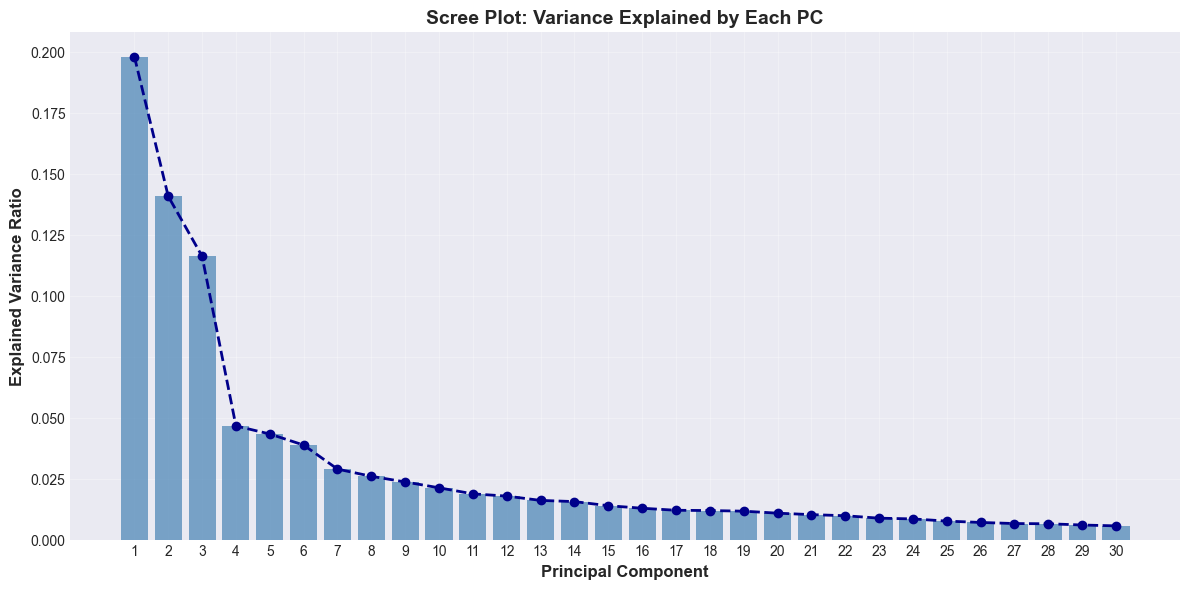

[INFO] Saved cumulative plot to ..\data\processed\deep_progression_artifacts\pca_cumulative.png


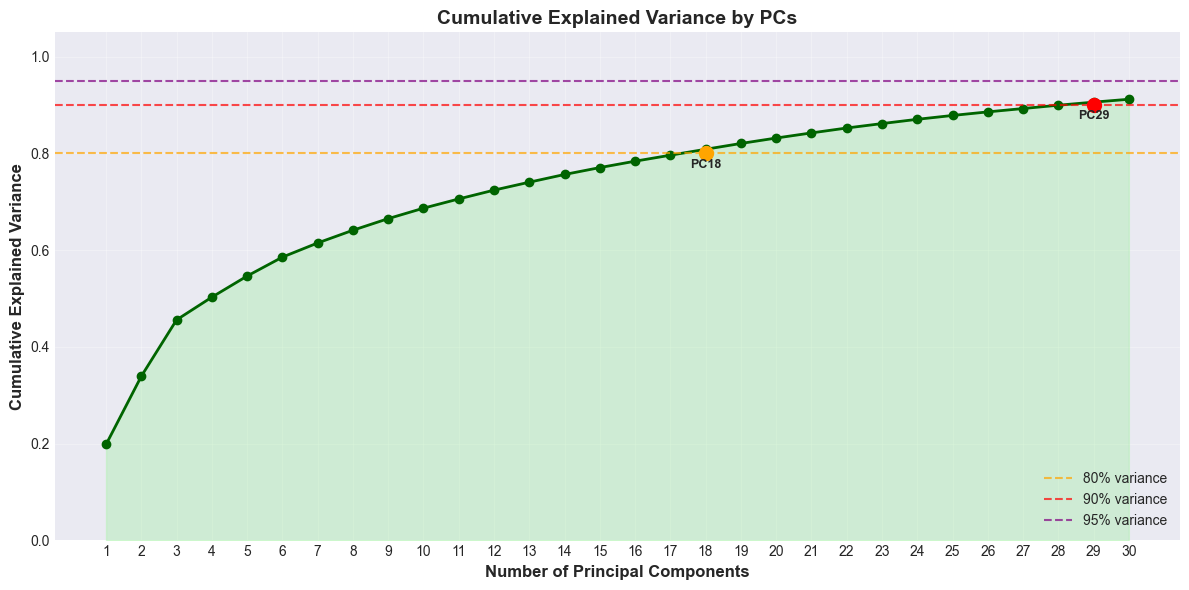

In [325]:
def plot_scree(explained_var_ratio: np.ndarray, max_components: int = 30, save_path: Path = None):
    """
    Create scree plot showing variance explained by each PC.
    """
    n_components = min(max_components, len(explained_var_ratio))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(1, n_components + 1)
    y = explained_var_ratio[:n_components]
    
    ax.bar(x, y, alpha=0.7, color='steelblue')
    ax.plot(x, y, marker='o', linestyle='--', color='darkblue', linewidth=2, markersize=6)
    
    ax.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
    ax.set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
    ax.set_title('Scree Plot: Variance Explained by Each PC', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(x)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved scree plot to {save_path}")
    
    plt.show()

def plot_cumulative(explained_var_ratio: np.ndarray, max_components: int = 30, save_path: Path = None):
    """
    Create cumulative variance plot with threshold lines.
    """
    cumulative = np.cumsum(explained_var_ratio)
    n_components = min(max_components, len(cumulative))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(1, n_components + 1)
    y = cumulative[:n_components]
    
    ax.plot(x, y, marker='o', linestyle='-', color='darkgreen', linewidth=2, markersize=6)
    ax.fill_between(x, y, alpha=0.3, color='lightgreen')
    
    # Threshold lines
    for threshold, label, color in [(0.80, '80%', 'orange'), (0.90, '90%', 'red'), (0.95, '95%', 'purple')]:
        ax.axhline(y=threshold, linestyle='--', color=color, linewidth=1.5, alpha=0.7, label=f'{label} variance')
        
        # Find first PC reaching threshold
        idx = np.where(cumulative >= threshold)[0]
        if len(idx) > 0 and idx[0] < n_components:
            pc_num = idx[0] + 1
            ax.plot(pc_num, threshold, 'o', color=color, markersize=10)
            ax.text(pc_num, threshold - 0.03, f'PC{pc_num}', ha='center', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
    ax.set_title('Cumulative Explained Variance by PCs', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(x)
    ax.set_ylim([0, 1.05])
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved cumulative plot to {save_path}")
    
    plt.show()

# Generate plots
log_message("\n" + "="*80)
log_message("GENERATING VISUALIZATIONS")
log_message("="*80)

plot_scree(explained_var_ratio, max_components=min(30, len(explained_var_ratio)), save_path=ARTIFACT_BASE / "pca_scree.png")
plot_cumulative(explained_var_ratio, max_components=min(30, len(explained_var_ratio)), save_path=ARTIFACT_BASE / "pca_cumulative.png")


## 15. Save Artifacts


In [326]:
def save_artifacts(
    artifact_dir: Path,
    features_used: list,
    explained_var: np.ndarray,
    explained_var_ratio: np.ndarray,
    dropped_features: dict,
    scaler_params: dict,
    winsorize_bounds: dict,
    include_360: bool,
    coverage_360: float,
    cohort_size: int,
    season_breakdown: dict
):
    """
    Save all artifacts for combined analysis.
    """
    log_message("\n" + "="*80)
    log_message("SAVING ARTIFACTS")
    log_message("="*80)
    
    # 1. Features used
    with open(artifact_dir / "pca_features_used.json", "w", encoding='utf-8') as f:
        json.dump(features_used, f, indent=2)
    log_message("✓ Saved features_used.json")
    
    # 2. Variance arrays
    np.save(artifact_dir / "pca_explained_variance.npy", explained_var)
    np.save(artifact_dir / "pca_explained_variance_ratio.npy", explained_var_ratio)
    log_message("✓ Saved variance arrays")
    
    # 3. Dropped features log
    with open(artifact_dir / "dropped_features_log.json", "w", encoding='utf-8') as f:
        json.dump(dropped_features, f, indent=2)
    log_message("✓ Saved dropped_features_log.json")
    
    # 4. Scaler params
    scaler_output = {
        "normalization_mode": NORMALIZATION_MODE,
        "parameters": scaler_params
    }
    with open(artifact_dir / "scaler_params.json", "w", encoding='utf-8') as f:
        json.dump(scaler_output, f, indent=2)
    log_message("✓ Saved scaler_params.json")
    
    # 5. Winsorize bounds
    with open(artifact_dir / "winsorize_bounds.json", "w", encoding='utf-8') as f:
        json.dump(winsorize_bounds, f, indent=2)
    log_message("✓ Saved winsorize_bounds.json")
    
    # 6. Data quality report
    cumulative = np.cumsum(explained_var_ratio)
    
    # Find PCs for thresholds
    pc_80 = np.where(cumulative >= 0.80)[0][0] + 1 if len(np.where(cumulative >= 0.80)[0]) > 0 else "N/A"
    pc_90 = np.where(cumulative >= 0.90)[0][0] + 1 if len(np.where(cumulative >= 0.90)[0]) > 0 else "N/A"
    pc_95 = np.where(cumulative >= 0.95)[0][0] + 1 if len(np.where(cumulative >= 0.95)[0]) > 0 else "N/A"
    
    # Build variance breakdown for first 10 PCs
    variance_breakdown_lines = []
    num_pcs_to_show = min(10, len(explained_var_ratio))
    for i in range(num_pcs_to_show):
        pc_num = i + 1
        individual_var = explained_var_ratio[i]
        cumulative_var = cumulative[i]
        variance_breakdown_lines.append(f"  - **PC{pc_num}:** {individual_var:.2%} (cumulative: {cumulative_var:.2%})")
    variance_breakdown = "\n".join(variance_breakdown_lines)
    
    # Build season breakdown string
    season_breakdown_lines = []
    for season_id, count in season_breakdown.items():
        season_breakdown_lines.append(f"  - Season {season_id}: {count} player-seasons")
    season_breakdown_str = "\n".join(season_breakdown_lines)
    
    # Calculate feature counts
    base_count = len(BASE_FEATURES)
    space_360_count = len(SPACE_360_FEATURES) if include_360 else 0
    total_extracted = base_count + space_360_count
    
    report = f"""# Data Quality Report: Deep Progression Unit (All Seasons Combined)

## Cohort
- **Total Size:** {cohort_size} player-seasons
- **Seasons:** {len(season_breakdown)} seasons combined
{season_breakdown_str}
- **Positions:** Wing Backs, Full Backs, Holding Midfielders, Central Midfielders
- **Minutes filter:** > {MIN_MINUTES}

## Features
- **Base features:** {base_count}
- **360 metrics:** {"Yes" if include_360 else "No"} (coverage: {coverage_360:.1%})
- **360 features added:** {space_360_count}
- **Total features extracted:** {total_extracted}
- **Features dropped:** {len(dropped_features)}
- **Final features for PCA:** {len(features_used)}

## Preprocessing
- **Missingness threshold:** >={MISSING_THRESHOLD:.0%}
- **Winsorization:** [{WINSORIZE_LIMITS[0]:.1%}, {WINSORIZE_LIMITS[1]:.1%}] percentiles
- **Normalization:** {NORMALIZATION_MODE}
- **Collinearity threshold:** |r| >= {COLLINEARITY_THRESHOLD}

## PCA Results
- **Total components:** {len(explained_var_ratio)}
- **Components for 80% variance:** {pc_80}
- **Components for 90% variance:** {pc_90}
- **Components for 95% variance:** {pc_95}

### Variance Explained by First 10 PCs
{variance_breakdown}

## Dropped Features
"""
    
    if dropped_features:
        for feat, reason in dropped_features.items():
            report += f"- **{feat}:** {reason}\n"
    else:
        report += "- None\n"
    
    with open(artifact_dir / "data_quality_report.md", "w", encoding='utf-8') as f:
        f.write(report)
    log_message("✓ Saved data_quality_report.md")
    
    log_message(f"\n✓ All artifacts saved to {artifact_dir}")

print("✓ Artifact save function defined")


✓ Artifact save function defined


## 16. Save All Artifacts


In [327]:
# Prepare dropped features dict
dropped_features = {
    **{f: "Missing from data" for f in missing_features},
    **{f: "360 coverage insufficient" for f in SPACE_360_FEATURES if not include_360},
    **dropped_missing,
    **dropped_collinear
}

# Get season breakdown
season_breakdown = combined_filtered['season_id'].value_counts().to_dict()

# Save all artifacts
save_artifacts(
    artifact_dir=ARTIFACT_BASE,
    features_used=features_final.columns.tolist(),
    explained_var=explained_var,
    explained_var_ratio=explained_var_ratio,
    dropped_features=dropped_features,
    scaler_params=scaler_params,
    winsorize_bounds=winsorize_bounds,
    include_360=include_360,
    coverage_360=coverage_360,
    cohort_size=len(combined_filtered),
    season_breakdown=season_breakdown
)


[INFO] 
[INFO] SAVING ARTIFACTS
[INFO] ================================================================================
[INFO] ✓ Saved features_used.json
[INFO] ✓ Saved variance arrays
[INFO] ✓ Saved dropped_features_log.json
[INFO] ✓ Saved scaler_params.json
[INFO] ✓ Saved winsorize_bounds.json
[INFO] ✓ Saved data_quality_report.md
[INFO] 
✓ All artifacts saved to ..\data\processed\deep_progression_artifacts


## 17. Final Summary


In [328]:
log_message("\n" + "="*80)
log_message("ANALYSIS COMPLETE!")
log_message("="*80)

log_message(f"\n📊 Final Summary:")
log_message(f"  - Total player-seasons: {len(combined_filtered)}")
log_message(f"  - Seasons: {list(season_breakdown.keys())}")
log_message(f"  - Features used: {len(features_final.columns)}")
log_message(f"  - Features dropped: {len(dropped_features)}")
log_message(f"  - 360 metrics included: {include_360}")
log_message(f"  - Total PCA components: {len(explained_var_ratio)}")
log_message(f"  - PCs for 80% variance: {pc_80}")
log_message(f"  - PCs for 90% variance: {pc_90}")
log_message(f"  - PCs for 95% variance: {pc_95}")
log_message(f"\n✓ All artifacts saved to: {ARTIFACT_BASE.absolute()}")


[INFO] 
[INFO] ANALYSIS COMPLETE!
[INFO] ================================================================================
[INFO] 
📊 Final Summary:
[INFO]   - Total player-seasons: 604
[INFO]   - Seasons: [281, 317, 235, 108]
[INFO]   - Features used: 76
[INFO]   - Features dropped: 10
[INFO]   - 360 metrics included: True
[INFO]   - Total PCA components: 76
[INFO]   - PCs for 80% variance: 18
[INFO]   - PCs for 90% variance: 29
[INFO]   - PCs for 95% variance: 39
[INFO] 
✓ All artifacts saved to: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\deep_progression_artifacts


## 18. PCA Loadings Analysis (First 7 PCs)

Investigate which features contribute most to each of the first 7 principal components.


In [329]:
def analyze_pc_loadings(pca_model, feature_names, n_pcs=7, top_n=10):
    """
    Analyze and display top loadings for each PC.
    
    Parameters:
    - pca_model: Fitted PCA model
    - feature_names: List of feature names
    - n_pcs: Number of PCs to analyze
    - top_n: Number of top features to show per PC
    """
    log_message("\n" + "="*80)
    log_message(f"LOADINGS ANALYSIS: FIRST {n_pcs} PCs")
    log_message("="*80)
    
    # Get loadings matrix (components)
    loadings = pca_model.components_[:n_pcs, :]
    
    results = {}
    
    for i in range(n_pcs):
        pc_num = i + 1
        pc_loadings = loadings[i, :]
        
        # Create DataFrame of loadings
        loading_df = pd.DataFrame({
            'feature': feature_names,
            'loading': pc_loadings,
            'abs_loading': np.abs(pc_loadings)
        }).sort_values('abs_loading', ascending=False)
        
        results[f'PC{pc_num}'] = loading_df
        
        log_message(f"\n{'='*60}")
        log_message(f"PC{pc_num} - Top {top_n} Features by Absolute Loading")
        log_message(f"{'='*60}")
        
        for idx, row in loading_df.head(top_n).iterrows():
            direction = "+" if row['loading'] > 0 else "-"
            log_message(f"  {direction} {row['feature']:50s} | {row['loading']:+.3f}")
    
    return results

# Analyze loadings
loading_results = analyze_pc_loadings(pca, features_final.columns.tolist(), n_pcs=7, top_n=10)


[INFO] 
[INFO] LOADINGS ANALYSIS: FIRST 7 PCs
[INFO] ================================================================================
[INFO] 
[INFO] PC1 - Top 10 Features by Absolute Loading
[INFO] ============================================================
[INFO]   + player_season_shots_key_passes_90                  | +0.223
[INFO]   + player_season_fhalf_lbp_received_90                | +0.206
[INFO]   + player_season_key_passes_90                        | +0.203
[INFO]   + player_season_op_key_passes_90                     | +0.196
[INFO]   + player_season_lbp_to_space_5_received_90           | +0.194
[INFO]   + player_season_average_x_pressure                   | +0.192
[INFO]   + player_season_positive_outcome_90                  | +0.185
[INFO]   + player_season_dispossessions_90                    | +0.179
[INFO]   + player_season_positive_outcome_score               | +0.178
[INFO]   + player_season_xgchain_90                           | +0.171
[INFO] 
[INFO] PC2 - Top 10 Fea

### Visualize Loadings Heatmap


[INFO] Saved loadings heatmap to ..\data\processed\deep_progression_artifacts\pca_loadings_heatmap.png


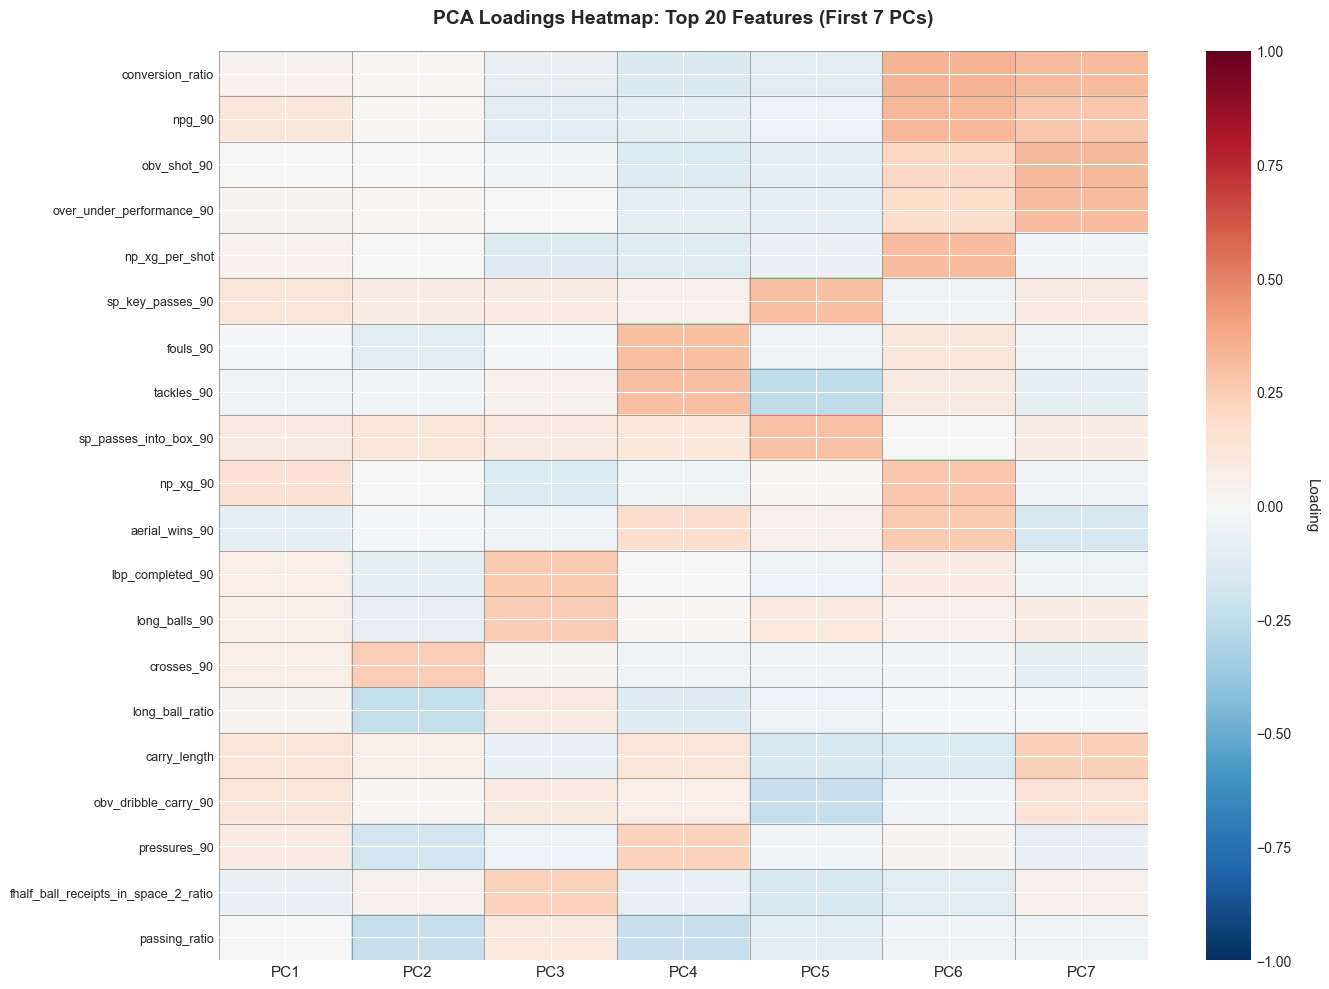

In [330]:
def plot_loadings_heatmap(pca_model, feature_names, n_pcs=7, top_n=15, save_path=None):
    """
    Create a heatmap of loadings for the first n_pcs, showing top_n features per PC.
    """
    # Get loadings
    loadings = pca_model.components_[:n_pcs, :]
    
    # Find top features across all PCs
    abs_loadings = np.abs(loadings)
    max_abs_loadings = abs_loadings.max(axis=0)
    top_feature_indices = np.argsort(max_abs_loadings)[-top_n:][::-1]
    
    # Create subset DataFrame
    loading_subset = loadings[:, top_feature_indices]
    feature_subset = [feature_names[i] for i in top_feature_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create heatmap
    im = ax.imshow(loading_subset.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    # Set ticks
    ax.set_xticks(np.arange(n_pcs))
    ax.set_yticks(np.arange(top_n))
    ax.set_xticklabels([f'PC{i+1}' for i in range(n_pcs)], fontsize=11)
    ax.set_yticklabels([f.replace('player_season_', '') for f in feature_subset], fontsize=9)
    
    # Rotate labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Loading', rotation=270, labelpad=20, fontsize=11)
    
    # Add title
    ax.set_title(f'PCA Loadings Heatmap: Top {top_n} Features (First {n_pcs} PCs)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add grid
    ax.set_xticks(np.arange(n_pcs+1)-.5, minor=True)
    ax.set_yticks(np.arange(top_n+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved loadings heatmap to {save_path}")
    
    plt.show()

# Create heatmap
plot_loadings_heatmap(pca, features_final.columns.tolist(), n_pcs=7, top_n=20, 
                      save_path=ARTIFACT_BASE / "pca_loadings_heatmap.png")


### Individual PC Loading Bars


[INFO] 
[INFO] GENERATING LOADING BAR PLOTS
[INFO] ================================================================================
[INFO] Saved loading bars to ..\data\processed\deep_progression_artifacts\pca_loadings_bars_PC1-3.png


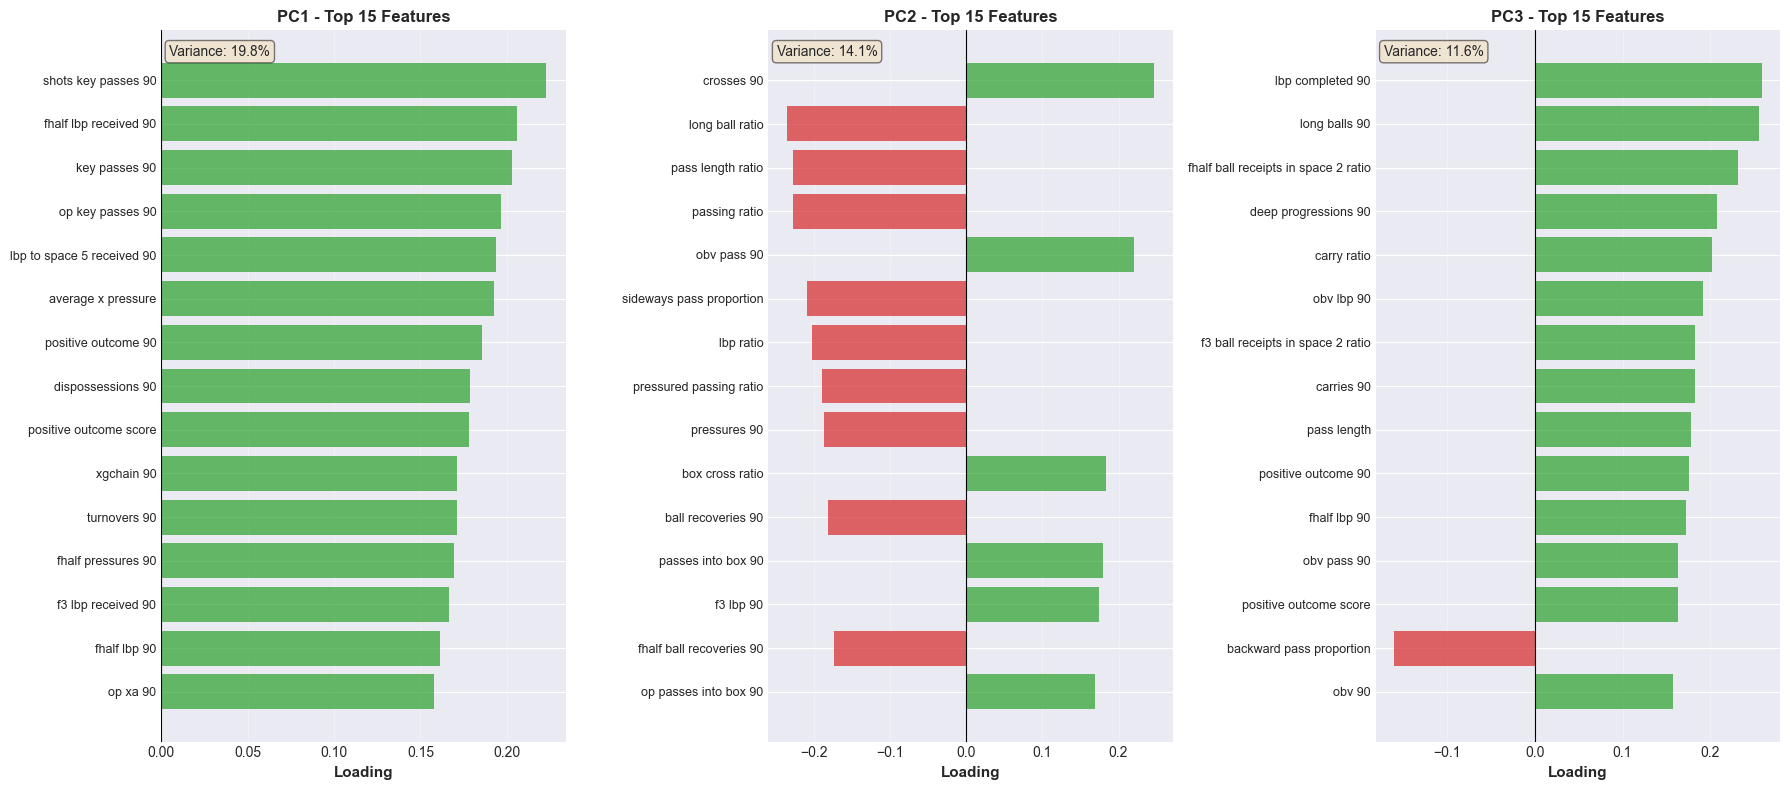

In [331]:
def plot_pc_loadings_bars(loading_results, pc_nums=[1, 2, 3], top_n=15, save_dir=None):
    """
    Create bar plots for individual PCs showing top loadings.
    """
    n_pcs = len(pc_nums)
    fig, axes = plt.subplots(1, n_pcs, figsize=(6*n_pcs, 8))
    
    if n_pcs == 1:
        axes = [axes]
    
    for idx, pc_num in enumerate(pc_nums):
        ax = axes[idx]
        pc_key = f'PC{pc_num}'
        
        # Get top features
        top_features = loading_results[pc_key].head(top_n).copy()
        top_features['short_name'] = top_features['feature'].str.replace('player_season_', '').str.replace('_', ' ')
        
        # Create bar plot
        colors = ['#d62728' if x < 0 else '#2ca02c' for x in top_features['loading']]
        ax.barh(range(len(top_features)), top_features['loading'], color=colors, alpha=0.7)
        
        # Customize
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['short_name'], fontsize=9)
        ax.invert_yaxis()
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax.set_xlabel('Loading', fontsize=11, fontweight='bold')
        ax.set_title(f'{pc_key} - Top {top_n} Features', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add variance explained
        var_explained = explained_var_ratio[pc_num-1]
        ax.text(0.02, 0.98, f'Variance: {var_explained:.1%}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_dir:
        save_path = save_dir / f"pca_loadings_bars_PC{pc_nums[0]}-{pc_nums[-1]}.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved loading bars to {save_path}")
    
    plt.show()

# Plot first 3 PCs
log_message("\n" + "="*80)
log_message("GENERATING LOADING BAR PLOTS")
log_message("="*80)

plot_pc_loadings_bars(loading_results, pc_nums=[1, 2, 3], top_n=15, save_dir=ARTIFACT_BASE)


### Save Loadings to Artifacts


In [332]:
def save_loadings_artifacts(pca_model, feature_names, artifact_dir, n_pcs=7):
    """
    Save PCA loadings to JSON and CSV for further analysis.
    """
    log_message("\n" + "="*80)
    log_message("SAVING LOADINGS ARTIFACTS")
    log_message("="*80)
    
    # Full loadings matrix
    loadings_df = pd.DataFrame(
        pca_model.components_.T,
        index=feature_names,
        columns=[f'PC{i+1}' for i in range(len(pca_model.components_))]
    )
    
    # Save full loadings
    loadings_df.to_csv(artifact_dir / "pca_loadings_full.csv")
    log_message("✓ Saved pca_loadings_full.csv")
    
    # Save first n_pcs loadings
    loadings_subset = loadings_df.iloc[:, :n_pcs]
    loadings_subset.to_csv(artifact_dir / f"pca_loadings_first_{n_pcs}.csv")
    log_message(f"✓ Saved pca_loadings_first_{n_pcs}.csv")
    
    # Create interpretation JSON with top features per PC
    interpretation = {}
    for i in range(n_pcs):
        pc_num = i + 1
        pc_loadings = pca_model.components_[i, :]
        
        # Get indices sorted by absolute loading
        sorted_indices = np.argsort(np.abs(pc_loadings))[::-1]
        
        # Top positive and negative
        positive_features = []
        negative_features = []
        
        for idx in sorted_indices[:20]:  # Top 20
            feat_name = feature_names[idx]
            loading = float(pc_loadings[idx])
            
            if loading > 0:
                positive_features.append({"feature": feat_name, "loading": loading})
            else:
                negative_features.append({"feature": feat_name, "loading": loading})
        
        interpretation[f'PC{pc_num}'] = {
            "variance_explained": float(explained_var_ratio[i]),
            "cumulative_variance": float(cumulative_var[i]),
            "top_positive_loadings": positive_features[:10],
            "top_negative_loadings": negative_features[:10]
        }
    
    with open(artifact_dir / "pca_loadings_interpretation.json", "w", encoding='utf-8') as f:
        json.dump(interpretation, f, indent=2)
    log_message("✓ Saved pca_loadings_interpretation.json")
    
    log_message(f"\n✓ All loading artifacts saved to {artifact_dir}")

# Save loadings
save_loadings_artifacts(pca, features_final.columns.tolist(), ARTIFACT_BASE, n_pcs=7)


[INFO] 
[INFO] SAVING LOADINGS ARTIFACTS
[INFO] ================================================================================
[INFO] ✓ Saved pca_loadings_full.csv
[INFO] ✓ Saved pca_loadings_first_7.csv
[INFO] ✓ Saved pca_loadings_interpretation.json
[INFO] 
✓ All loading artifacts saved to ..\data\processed\deep_progression_artifacts


### Summary: First 7 PCs Interpretation Helper


In [333]:
def print_pc_summary(loading_results, explained_var_ratio, n_pcs=7):
    """
    Print a concise summary of what each PC represents based on loadings.
    """
    log_message("\n" + "="*80)
    log_message("PC INTERPRETATION SUMMARY")
    log_message("="*80)
    
    for i in range(n_pcs):
        pc_num = i + 1
        pc_key = f'PC{pc_num}'
        var_exp = explained_var_ratio[i]
        
        # Get top 5 positive and negative
        top_df = loading_results[pc_key].head(10)
        
        positive = top_df[top_df['loading'] > 0].head(5)
        negative = top_df[top_df['loading'] < 0].head(5)
        
        log_message(f"\n{pc_key} ({var_exp:.1%} variance):")
        log_message("-" * 60)
        
        if len(positive) > 0:
            log_message("  HIGH (+):")
            for _, row in positive.iterrows():
                short_name = row['feature'].replace('player_season_', '').replace('_', ' ')
                log_message(f"    • {short_name}")
        
        if len(negative) > 0:
            log_message("  LOW (-):")
            for _, row in negative.iterrows():
                short_name = row['feature'].replace('player_season_', '').replace('_', ' ')
                log_message(f"    • {short_name}")

# Print interpretation summary
print_pc_summary(loading_results, explained_var_ratio, n_pcs=7)


[INFO] 
[INFO] PC INTERPRETATION SUMMARY
[INFO] ================================================================================
[INFO] 
PC1 (19.8% variance):
[INFO] ------------------------------------------------------------
[INFO]   HIGH (+):
[INFO]     • shots key passes 90
[INFO]     • fhalf lbp received 90
[INFO]     • key passes 90
[INFO]     • op key passes 90
[INFO]     • lbp to space 5 received 90
[INFO] 
PC2 (14.1% variance):
[INFO] ------------------------------------------------------------
[INFO]   HIGH (+):
[INFO]     • crosses 90
[INFO]     • obv pass 90
[INFO]     • box cross ratio
[INFO]   LOW (-):
[INFO]     • long ball ratio
[INFO]     • pass length ratio
[INFO]     • passing ratio
[INFO]     • sideways pass proportion
[INFO]     • lbp ratio
[INFO] 
PC3 (11.6% variance):
[INFO] ------------------------------------------------------------
[INFO]   HIGH (+):
[INFO]     • lbp completed 90
[INFO]     • long balls 90
[INFO]     • fhalf ball receipts in space 2 ratio
[INF

## 19. Compute PCA Scores (7D Ability Space)

Transform the normalized feature data into the 7-dimensional ability space using the first 7 PCs.


In [334]:
log_message("\n" + "="*80)
log_message("COMPUTING PCA SCORES (7D ABILITY SPACE)")
log_message("="*80)

# Transform to 7D space
n_components_for_clustering = 7
pca_scores_7d = pca.transform(features_final)[:, :n_components_for_clustering]

log_message(f"Transformed {len(features_final)} player-seasons to {n_components_for_clustering}D space")

# Create DataFrame with player info and PCA scores
pca_scores_df = combined_filtered[['player_id', 'player_name', 'team_name', 'season_id', 
                                     'season_name', 'primary_position', 'secondary_position',
                                     'player_season_minutes']].copy()

# Add PCA scores
for i in range(n_components_for_clustering):
    pca_scores_df[f'PC{i+1}'] = pca_scores_7d[:, i]

# Save PCA scores
pca_scores_path = ARTIFACT_BASE / "pca_scores_player_season.csv"
pca_scores_df.to_csv(pca_scores_path, index=False)
log_message(f"✓ Saved PCA scores to {pca_scores_path}")

print(f"\n✓ PCA scores shape: {pca_scores_7d.shape}")
print(f"Sample scores (first player):")
print(pca_scores_df[['player_name', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']].head(1))


[INFO] 
[INFO] COMPUTING PCA SCORES (7D ABILITY SPACE)
[INFO] ================================================================================
[INFO] Transformed 604 player-seasons to 7D space
[INFO] ✓ Saved PCA scores to ..\data\processed\deep_progression_artifacts\pca_scores_player_season.csv

✓ PCA scores shape: (604, 7)
Sample scores (first player):
                  player_name       PC1      PC2       PC3       PC4  \
5  Fernando David Arce Juárez -2.049897 -4.29298 -3.308287 -0.833532   

        PC5       PC6       PC7  
5 -1.740285  6.222484  4.891057  


## 20. Prepare Data for Clustering

Apply L2 normalization to the 7D ability vectors to capture **style** (relative ability distribution) rather than performance magnitude.


In [335]:
log_message("\n" + "="*80)
log_message("PREPARING DATA FOR CLUSTERING")
log_message("="*80)

# Extract 7D ability vectors
ability_columns = [f'PC{i+1}' for i in range(n_components_for_clustering)]
abilities_raw = pca_scores_df[ability_columns].values.copy()

log_message(f"Raw abilities shape: {abilities_raw.shape}")

# Apply L2 normalization (row-wise)
norms = np.linalg.norm(abilities_raw, axis=1, keepdims=True)
norms[norms == 0] = 1.0  # Avoid division by zero
abilities_l2_normalized = abilities_raw / norms

log_message("Applied L2 normalization (row-wise) to 7D ability vectors")
log_message("→ Clustering will capture STYLE (relative ability distribution)")

# Save both versions
np.save(ARTIFACT_BASE / "abilities_raw_7d.npy", abilities_raw)
np.save(ARTIFACT_BASE / "abilities_l2_normalized_7d.npy", abilities_l2_normalized)
log_message("✓ Saved raw and L2-normalized abilities")

print(f"\n✓ L2-normalized abilities shape: {abilities_l2_normalized.shape}")
print(f"Sample L2 norm check (should be ~1.0): {np.linalg.norm(abilities_l2_normalized[0]):.6f}")


[INFO] 
[INFO] PREPARING DATA FOR CLUSTERING
[INFO] ================================================================================
[INFO] Raw abilities shape: (604, 7)
[INFO] Applied L2 normalization (row-wise) to 7D ability vectors
[INFO] → Clustering will capture STYLE (relative ability distribution)
[INFO] ✓ Saved raw and L2-normalized abilities

✓ L2-normalized abilities shape: (604, 7)
Sample L2 norm check (should be ~1.0): 1.000000


## 21. GMM Cluster Count Selection

Fit Gaussian Mixture Models with different cluster counts (k=2 to k=10) and evaluate using BIC and AIC.


In [336]:
from sklearn.mixture import GaussianMixture

def fit_gmm_k_range(X, k_values, random_state=42):
    """
    Fit GMM for a range of k values and compute BIC/AIC.
    
    Parameters:
    - X: Feature matrix (n_samples, n_features)
    - k_values: List of k values to test
    - random_state: Random seed for reproducibility
    
    Returns:
    - results: List of dicts with k, BIC, AIC, model
    """
    results = []
    
    log_message("\n" + "="*80)
    log_message("FITTING GMM FOR DIFFERENT K VALUES")
    log_message("="*80)
    
    for k in k_values:
        log_message(f"\nFitting GMM with k={k}...")
        
        gmm = GaussianMixture(
            n_components=k,
            covariance_type='full',
            random_state=random_state,
            max_iter=200,
            n_init=10
        )
        
        gmm.fit(X)
        
        bic = gmm.bic(X)
        aic = gmm.aic(X)
        
        results.append({
            'k': k,
            'BIC': bic,
            'AIC': aic,
            'model': gmm,
            'converged': gmm.converged_
        })
        
        log_message(f"  k={k} | BIC={bic:.2f} | AIC={aic:.2f} | Converged={gmm.converged_}")
    
    return results

# Test k values
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Fit GMMs
gmm_results = fit_gmm_k_range(abilities_l2_normalized, k_values, random_state=RANDOM_SEED)

log_message("\n✓ GMM fitting complete for all k values")


[INFO] 
[INFO] FITTING GMM FOR DIFFERENT K VALUES
[INFO] ================================================================================
[INFO] 
Fitting GMM with k=2...
[INFO]   k=2 | BIC=2898.57 | AIC=2585.92 | Converged=True
[INFO] 
Fitting GMM with k=3...
[INFO]   k=3 | BIC=2859.09 | AIC=2387.90 | Converged=True
[INFO] 
Fitting GMM with k=4...
[INFO]   k=4 | BIC=2874.51 | AIC=2244.80 | Converged=True
[INFO] 
Fitting GMM with k=5...
[INFO]   k=5 | BIC=2911.35 | AIC=2123.11 | Converged=True
[INFO] 
Fitting GMM with k=6...
[INFO]   k=6 | BIC=3006.52 | AIC=2059.75 | Converged=True
[INFO] 
Fitting GMM with k=7...
[INFO]   k=7 | BIC=3107.38 | AIC=2002.08 | Converged=True
[INFO] 
Fitting GMM with k=8...
[INFO]   k=8 | BIC=3190.72 | AIC=1926.89 | Converged=True
[INFO] 
Fitting GMM with k=9...
[INFO]   k=9 | BIC=3298.85 | AIC=1876.50 | Converged=True
[INFO] 
Fitting GMM with k=10...
[INFO]   k=10 | BIC=3441.42 | AIC=1860.54 | Converged=True
[INFO] 
✓ GMM fitting complete for all k values


### Save GMM Selection Results


In [337]:
log_message("\n" + "="*80)
log_message("SAVING GMM SELECTION RESULTS")
log_message("="*80)

# Create GMM selection directory
gmm_selection_dir = ARTIFACT_BASE / "gmm_selection"
gmm_selection_dir.mkdir(parents=True, exist_ok=True)

# Save results to CSV
gmm_results_df = pd.DataFrame([
    {'k': r['k'], 'BIC': r['BIC'], 'AIC': r['AIC'], 'converged': r['converged']}
    for r in gmm_results
])

csv_path = gmm_selection_dir / "gmm_k_selection.csv"
gmm_results_df.to_csv(csv_path, index=False)
log_message(f"✓ Saved GMM results to {csv_path}")

# Find best k values
best_bic_k = gmm_results_df.loc[gmm_results_df['BIC'].idxmin(), 'k']
best_aic_k = gmm_results_df.loc[gmm_results_df['AIC'].idxmin(), 'k']

# Save summary JSON
summary = {
    "cohort": "Deep Progression Unit (All Seasons Combined)",
    "n_observations": int(len(abilities_l2_normalized)),
    "n_dimensions": n_components_for_clustering,
    "normalization": "L2 (row-wise)",
    "tested_k": k_values,
    "best_bic_k": int(best_bic_k),
    "best_aic_k": int(best_aic_k),
    "covariance_type": "full",
    "random_state": RANDOM_SEED
}

json_path = gmm_selection_dir / "gmm_k_selection_summary.json"
with open(json_path, "w", encoding='utf-8') as f:
    json.dump(summary, f, indent=2)
log_message(f"✓ Saved summary to {json_path}")

print("\n" + "="*80)
print("GMM SELECTION SUMMARY")
print("="*80)
print(f"Best k by BIC: {best_bic_k}")
print(f"Best k by AIC: {best_aic_k}")
print("\nAll results:")
print(gmm_results_df.to_string(index=False))


[INFO] 
[INFO] SAVING GMM SELECTION RESULTS
[INFO] ================================================================================
[INFO] ✓ Saved GMM results to ..\data\processed\deep_progression_artifacts\gmm_selection\gmm_k_selection.csv
[INFO] ✓ Saved summary to ..\data\processed\deep_progression_artifacts\gmm_selection\gmm_k_selection_summary.json

GMM SELECTION SUMMARY
Best k by BIC: 3
Best k by AIC: 10

All results:
 k         BIC         AIC  converged
 2 2898.570170 2585.916402       True
 3 2859.086361 2387.903922       True
 4 2874.507996 2244.796885       True
 5 2911.348379 2123.108598       True
 6 3006.518208 2059.749756       True
 7 3107.380872 2002.083748       True
 8 3190.718759 1926.892965       True
 9 3298.852039 1876.497573       True
10 3441.420079 1860.536942       True


### Visualize BIC/AIC Curves


[INFO] 
[INFO] GENERATING BIC/AIC CURVES
[INFO] ================================================================================
[INFO] Saved BIC/AIC plot to ..\data\processed\deep_progression_artifacts\gmm_selection\gmm_bic_aic_curves.png


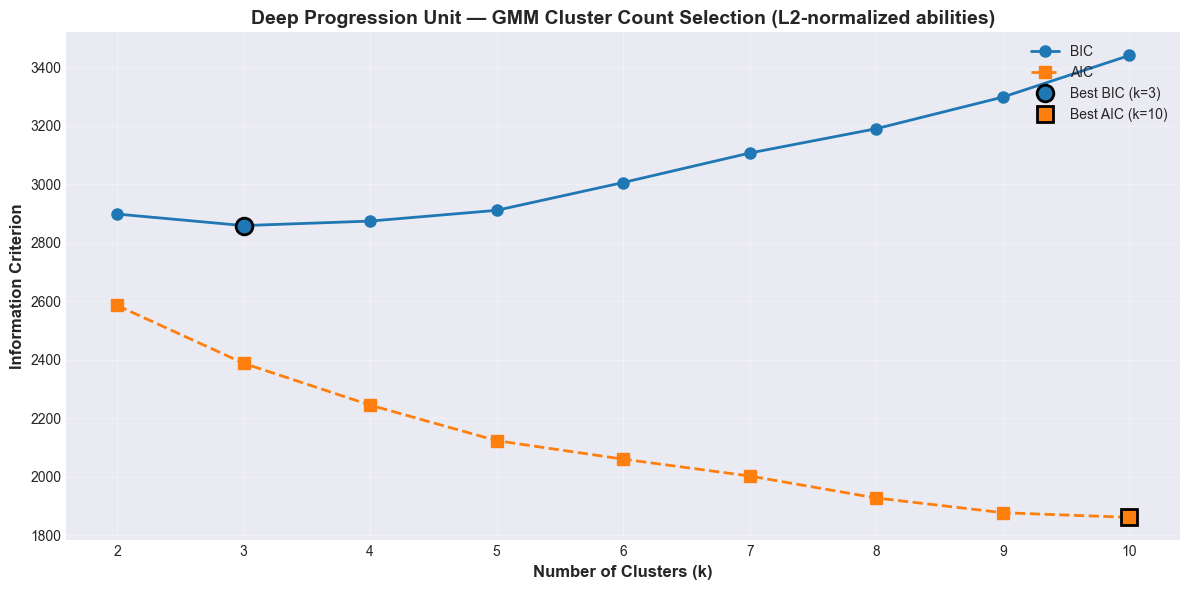

In [338]:
def plot_bic_aic_curves(results_df, save_path=None):
    """
    Plot BIC and AIC curves for GMM cluster count selection.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    k_vals = results_df['k'].values
    bic_vals = results_df['BIC'].values
    aic_vals = results_df['AIC'].values
    
    # Plot BIC
    ax.plot(k_vals, bic_vals, marker='o', linewidth=2, markersize=8, 
            label='BIC', color='#1f77b4', linestyle='-')
    
    # Plot AIC
    ax.plot(k_vals, aic_vals, marker='s', linewidth=2, markersize=8,
            label='AIC', color='#ff7f0e', linestyle='--')
    
    # Mark best k values
    best_bic_idx = results_df['BIC'].idxmin()
    best_aic_idx = results_df['AIC'].idxmin()
    
    ax.plot(results_df.loc[best_bic_idx, 'k'], results_df.loc[best_bic_idx, 'BIC'],
            'o', markersize=12, color='#1f77b4', markeredgecolor='black', markeredgewidth=2,
            label=f"Best BIC (k={int(results_df.loc[best_bic_idx, 'k'])})")
    
    ax.plot(results_df.loc[best_aic_idx, 'k'], results_df.loc[best_aic_idx, 'AIC'],
            's', markersize=12, color='#ff7f0e', markeredgecolor='black', markeredgewidth=2,
            label=f"Best AIC (k={int(results_df.loc[best_aic_idx, 'k'])})")
    
    # Formatting
    ax.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Information Criterion', fontsize=12, fontweight='bold')
    ax.set_title('Deep Progression Unit — GMM Cluster Count Selection (L2-normalized abilities)',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(k_vals)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved BIC/AIC plot to {save_path}")
    
    plt.show()

# Generate plot
log_message("\n" + "="*80)
log_message("GENERATING BIC/AIC CURVES")
log_message("="*80)

plot_bic_aic_curves(gmm_results_df, save_path=gmm_selection_dir / "gmm_bic_aic_curves.png")


### Additional Diagnostic Plots


[INFO] Saved elbow plot to ..\data\processed\deep_progression_artifacts\gmm_selection\gmm_elbow_plot.png


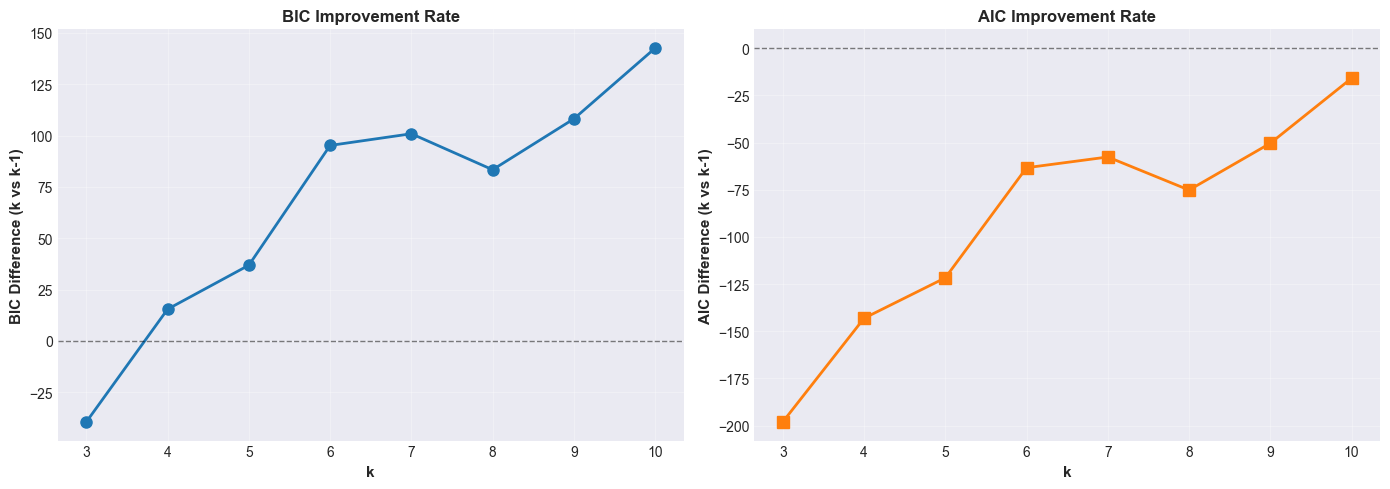

In [339]:
def plot_elbow_method(results_df, save_path=None):
    """
    Create elbow plot showing rate of BIC/AIC improvement.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    k_vals = results_df['k'].values
    
    # BIC elbow
    ax = axes[0]
    bic_vals = results_df['BIC'].values
    bic_diff = np.diff(bic_vals)
    
    ax.plot(k_vals[1:], bic_diff, marker='o', linewidth=2, markersize=8, color='#1f77b4')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('k', fontsize=11, fontweight='bold')
    ax.set_ylabel('BIC Difference (k vs k-1)', fontsize=11, fontweight='bold')
    ax.set_title('BIC Improvement Rate', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(k_vals[1:])
    
    # AIC elbow
    ax = axes[1]
    aic_vals = results_df['AIC'].values
    aic_diff = np.diff(aic_vals)
    
    ax.plot(k_vals[1:], aic_diff, marker='s', linewidth=2, markersize=8, color='#ff7f0e')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('k', fontsize=11, fontweight='bold')
    ax.set_ylabel('AIC Difference (k vs k-1)', fontsize=11, fontweight='bold')
    ax.set_title('AIC Improvement Rate', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(k_vals[1:])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"Saved elbow plot to {save_path}")
    
    plt.show()

# Generate elbow plot
plot_elbow_method(gmm_results_df, save_path=gmm_selection_dir / "gmm_elbow_plot.png")


## 22. Final GMM Selection Summary


In [340]:
log_message("\n" + "="*80)
log_message("🎯 FINAL GMM SELECTION SUMMARY")
log_message("="*80)

log_message(f"\n📊 Analysis Summary:")
log_message(f"  - Cohort: Deep Progression Unit (All Seasons)")
log_message(f"  - Observations: {len(abilities_l2_normalized)} player-seasons")
log_message(f"  - Dimensions: {n_components_for_clustering}D ability space")
log_message(f"  - Normalization: L2 (row-wise) for style-based clustering")
log_message(f"  - K values tested: {k_values}")
log_message(f"  - Covariance type: full")

log_message(f"\n🏆 Best Cluster Counts:")
log_message(f"  - By BIC: k = {best_bic_k}")
log_message(f"  - By AIC: k = {best_aic_k}")

log_message(f"\n📁 Artifacts saved to:")
log_message(f"  - {gmm_selection_dir.absolute()}")
log_message(f"    • gmm_k_selection.csv")
log_message(f"    • gmm_k_selection_summary.json")
log_message(f"    • gmm_bic_aic_curves.png")
log_message(f"    • gmm_elbow_plot.png")

log_message(f"\n✓ GMM cluster count analysis complete!")

# Display recommendation
print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)
print(f"Based on BIC (stricter penalty): k = {best_bic_k} clusters")
print(f"Based on AIC (more flexible): k = {best_aic_k} clusters")
print("\nNext steps:")
print("  1. Review the BIC/AIC curves and elbow plots")
print("  2. Consider domain knowledge about player roles")
print("  3. Fit final GMM with chosen k and analyze cluster characteristics")
print("="*80)


[INFO] 
[INFO] 🎯 FINAL GMM SELECTION SUMMARY
[INFO] ================================================================================
[INFO] 
📊 Analysis Summary:
[INFO]   - Cohort: Deep Progression Unit (All Seasons)
[INFO]   - Observations: 604 player-seasons
[INFO]   - Dimensions: 7D ability space
[INFO]   - Normalization: L2 (row-wise) for style-based clustering
[INFO]   - K values tested: [2, 3, 4, 5, 6, 7, 8, 9, 10]
[INFO]   - Covariance type: full
[INFO] 
🏆 Best Cluster Counts:
[INFO]   - By BIC: k = 3
[INFO]   - By AIC: k = 10
[INFO] 
📁 Artifacts saved to:
[INFO]   - c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\deep_progression_artifacts\gmm_selection
[INFO]     • gmm_k_selection.csv
[INFO]     • gmm_k_selection_summary.json
[INFO]     • gmm_bic_aic_curves.png
[INFO]     • gmm_elbow_plot.png
[INFO] 
✓ GMM cluster count analysis complete!

RECOMMENDATION
Based on BIC (stricter penalty): k = 3

## 23. Final GMM Clustering (k = 4)

Fit the final Gaussian Mixture Model with k=4 clusters (testing with 6D space).


In [341]:
import joblib
from sklearn.metrics import silhouette_score
from datetime import datetime

# Configuration
K = 3  # Testing k=4 with 6D space (was 0.21 silhouette with 7D)
COVARIANCE_TYPE = "full"
REG_COVAR = 1e-6

log_message("\n" + "="*80)
log_message(f"FINAL GMM CLUSTERING (k={K})")
log_message("="*80)
log_message(f"Configuration:")
log_message(f"  - k = {K}")
log_message(f"  - Covariance type: {COVARIANCE_TYPE}")
log_message(f"  - Random state: {RANDOM_SEED}")
log_message(f"  - Regularization: {REG_COVAR}")
log_message(f"  - Normalization: L2 (row-wise)")

print(f"✓ Configuration set for k={K}")


[INFO] 
[INFO] FINAL GMM CLUSTERING (k=3)
[INFO] ================================================================================
[INFO] Configuration:
[INFO]   - k = 3
[INFO]   - Covariance type: full
[INFO]   - Random state: 42
[INFO]   - Regularization: 1e-06
[INFO]   - Normalization: L2 (row-wise)
✓ Configuration set for k=3


### Fit Final GMM Model


In [342]:
log_message("\n" + "="*80)
log_message(f"FITTING FINAL GMM (k={K})")
log_message("="*80)

# Fit GMM
gmm_final = GaussianMixture(
    n_components=K,
    covariance_type=COVARIANCE_TYPE,
    random_state=RANDOM_SEED,
    reg_covar=REG_COVAR,
    max_iter=200,
    n_init=10
)

gmm_final.fit(abilities_l2_normalized)

# Compute metrics
bic_final = gmm_final.bic(abilities_l2_normalized)
aic_final = gmm_final.aic(abilities_l2_normalized)
labels_final = gmm_final.predict(abilities_l2_normalized)
silhouette_final = silhouette_score(abilities_l2_normalized, labels_final)

log_message(f"\n✓ GMM fitted successfully")
log_message(f"  - Converged: {gmm_final.converged_}")
log_message(f"  - Iterations: {gmm_final.n_iter_}")
log_message(f"  - BIC: {bic_final:.2f}")
log_message(f"  - AIC: {aic_final:.2f}")
log_message(f"  - Silhouette score: {silhouette_final:.4f}")

# Check cluster sizes
unique, counts = np.unique(labels_final, return_counts=True)
log_message(f"\nCluster sizes:")
for cluster_id, count in zip(unique, counts):
    pct = 100 * count / len(labels_final)
    log_message(f"  - Cluster {cluster_id}: {count} ({pct:.1f}%)")
    if pct < 2.0:
        log_message(f"    ⚠ WARNING: Small cluster (<2% of cohort)", "WARNING")

print(f"\n✓ Final GMM fitted with k={K}")


[INFO] 
[INFO] FITTING FINAL GMM (k=3)
[INFO] ================================================================================
[INFO] 
✓ GMM fitted successfully
[INFO]   - Converged: True
[INFO]   - Iterations: 6
[INFO]   - BIC: 2859.09
[INFO]   - AIC: 2387.90
[INFO]   - Silhouette score: 0.2447
[INFO] 
Cluster sizes:
[INFO]   - Cluster 0: 178 (29.5%)
[INFO]   - Cluster 1: 243 (40.2%)
[INFO]   - Cluster 2: 183 (30.3%)

✓ Final GMM fitted with k=3


### Assign Clusters & Compute Probabilities


In [343]:
log_message("\n" + "="*80)
log_message("ASSIGNING CLUSTERS & COMPUTING PROBABILITIES")
log_message("="*80)

# Add cluster assignments to dataframe
pca_scores_df['cluster'] = labels_final

# Compute probabilities
probs = gmm_final.predict_proba(abilities_l2_normalized)
prob_df = pd.DataFrame(
    probs,
    columns=[f'p_c{i}' for i in range(K)]
)

# Add player keys to prob_df
prob_df['player_id'] = pca_scores_df['player_id'].values
prob_df['season_id'] = pca_scores_df['season_id'].values

log_message(f"✓ Assigned {len(pca_scores_df)} player-seasons to {K} clusters")
log_message(f"✓ Computed membership probabilities")

print(f"\nCluster assignment distribution:")
print(pca_scores_df['cluster'].value_counts().sort_index())


[INFO] 
[INFO] ASSIGNING CLUSTERS & COMPUTING PROBABILITIES
[INFO] ================================================================================
[INFO] ✓ Assigned 604 player-seasons to 3 clusters
[INFO] ✓ Computed membership probabilities

Cluster assignment distribution:
cluster
0    178
1    243
2    183
Name: count, dtype: int64


### Compute Centroids (Raw & L2-Style)


In [344]:
log_message("\n" + "="*80)
log_message("COMPUTING CLUSTER CENTROIDS")
log_message("="*80)

# 1. Raw centroids (mean of original PC scores, not L2 normalized)
centroids_raw = pca_scores_df.groupby('cluster')[ability_columns].mean()
log_message(f"✓ Computed raw centroids (quality context)")

# 2. L2-style centroids (for style interpretation)
# Mean of L2-normalized vectors, then L2 normalize the centroid
centroids_l2_list = []
for c in range(K):
    cluster_mask = labels_final == c
    cluster_abilities_l2 = abilities_l2_normalized[cluster_mask]
    centroid_mean = cluster_abilities_l2.mean(axis=0)
    # L2 normalize the centroid
    centroid_l2_norm = centroid_mean / np.linalg.norm(centroid_mean)
    centroids_l2_list.append(centroid_l2_norm)

centroids_l2_style = pd.DataFrame(
    centroids_l2_list,
    columns=ability_columns,
    index=range(K)
)
centroids_l2_style.index.name = 'cluster'
log_message(f"✓ Computed L2-style centroids (style patterns)")

print("\nRaw centroids (first 3 PCs):")
print(centroids_raw[['PC1', 'PC2', 'PC3']].round(3))

print("\nL2-style centroids (first 3 PCs):")
print(centroids_l2_style[['PC1', 'PC2', 'PC3']].round(3))


[INFO] 
[INFO] COMPUTING CLUSTER CENTROIDS
[INFO] ================================================================================
[INFO] ✓ Computed raw centroids (quality context)
[INFO] ✓ Computed L2-style centroids (style patterns)

Raw centroids (first 3 PCs):
           PC1    PC2    PC3
cluster                     
0        4.821 -0.062 -0.375
1       -2.106  2.820  0.374
2       -1.893 -3.684 -0.132

L2-style centroids (first 3 PCs):
           PC1    PC2    PC3
cluster                     
0        0.988 -0.035 -0.072
1       -0.590  0.779  0.102
2       -0.456 -0.888 -0.028


### Position Counts per Cluster


In [345]:
log_message("\n" + "="*80)
log_message("COMPUTING POSITION COUNTS PER CLUSTER")
log_message("="*80)

# Primary position counts
counts_primary = pca_scores_df.groupby(['cluster', 'primary_position']).size().reset_index(name='count')

# Pivot to wide format (clusters x positions)
position_counts_wide = counts_primary.pivot(index='cluster', columns='primary_position', values='count').fillna(0).astype(int)

# Add percentages per cluster
position_counts_pct = position_counts_wide.div(position_counts_wide.sum(axis=1), axis=0) * 100

log_message(f"✓ Computed position counts by primary_position")

# Also count by primary AND secondary (each player counted for both if applicable)
counts_combined = []

for idx, row in pca_scores_df.iterrows():
    cluster = row['cluster']
    # Add primary
    counts_combined.append({
        'cluster': cluster,
        'position': row['primary_position']
    })
    # Add secondary if not null
    if pd.notna(row['secondary_position']) and row['secondary_position'] != '':
        counts_combined.append({
            'cluster': cluster,
            'position': row['secondary_position']
        })

counts_combined_df = pd.DataFrame(counts_combined)
counts_primary_secondary = counts_combined_df.groupby(['cluster', 'position']).size().reset_index(name='count')

# Pivot
position_counts_combined_wide = counts_primary_secondary.pivot(
    index='cluster', columns='position', values='count'
).fillna(0).astype(int)

log_message(f"✓ Computed position counts including secondary_position")

print("\nPosition distribution per cluster (primary only, top 5 positions):")
for c in range(K):
    if c in position_counts_wide.index:
        top_positions = position_counts_wide.loc[c].nlargest(5)
        print(f"\nCluster {c}:")
        for pos, count in top_positions.items():
            pct = position_counts_pct.loc[c, pos]
            print(f"  - {pos}: {int(count)} ({pct:.1f}%)")


[INFO] 
[INFO] COMPUTING POSITION COUNTS PER CLUSTER
[INFO] ================================================================================
[INFO] ✓ Computed position counts by primary_position
[INFO] ✓ Computed position counts including secondary_position

Position distribution per cluster (primary only, top 5 positions):

Cluster 0:
  - Right Defensive Midfielder: 44 (24.7%)
  - Left Defensive Midfielder: 43 (24.2%)
  - Left Centre Midfielder: 29 (16.3%)
  - Right Centre Midfielder: 22 (12.4%)
  - Left Wing Back: 13 (7.3%)

Cluster 1:
  - Right Back: 111 (45.7%)
  - Left Back: 93 (38.3%)
  - Left Wing Back: 21 (8.6%)
  - Right Wing Back: 16 (6.6%)
  - Left Defensive Midfielder: 1 (0.4%)

Cluster 2:
  - Right Defensive Midfielder: 85 (46.4%)
  - Left Defensive Midfielder: 57 (31.1%)
  - Centre Defensive Midfielder: 23 (12.6%)
  - Right Back: 7 (3.8%)
  - Left Centre Midfielder: 4 (2.2%)


In [346]:
log_message("\n" + "="*80)
log_message(f"SAVING GMM k={K} ARTIFACTS")
log_message("="*80)

# Create directory structure
gmm_k6_dir = ARTIFACT_BASE / f"gmm_k{K}"
gmm_k6_dir.mkdir(parents=True, exist_ok=True)
plots_dir = gmm_k6_dir / "plots"
plots_dir.mkdir(exist_ok=True)

# 1. Save GMM model
model_path = gmm_k6_dir / f"gmm_model_k{K}.joblib"
joblib.dump(gmm_final, model_path)
log_message(f"✓ Saved model: {model_path.name}")

# 2. Model summary
model_summary = {
    "k": K,
    "covariance_type": COVARIANCE_TYPE,
    "random_state": RANDOM_SEED,
    "reg_covar": REG_COVAR,
    "converged": bool(gmm_final.converged_),
    "n_iter": int(gmm_final.n_iter_),
    "bic": float(bic_final),
    "aic": float(aic_final),
    "silhouette": float(silhouette_final),
    "n_observations": int(len(abilities_l2_normalized)),
    "n_dimensions": n_components_for_clustering,
    "normalization": "L2 (row-wise)"
}

with open(gmm_k6_dir / "model_summary.json", "w", encoding='utf-8') as f:
    json.dump(model_summary, f, indent=2)
log_message(f"✓ Saved model_summary.json")

# 3. Abilities used
with open(gmm_k6_dir / "abilities_used.json", "w", encoding='utf-8') as f:
    json.dump(ability_columns, f, indent=2)
log_message(f"✓ Saved abilities_used.json")

# 4. Run config
run_config = {
    "timestamp": datetime.now().isoformat(),
    "cohort": "Deep Progression Unit (All Seasons Combined)",
    "k": K,
    "random_state": RANDOM_SEED,
    "l2_normalized": True,
    "input_file": "pca_scores_player_season.csv",
    "n_observations": int(len(pca_scores_df)),
    "seasons": [int(x) for x in pca_scores_df['season_id'].unique()]
}

with open(gmm_k6_dir / "run_config.json", "w", encoding='utf-8') as f:
    json.dump(run_config, f, indent=2)
log_message(f"✓ Saved run_config.json")

# 5. Cluster assignments
cluster_assignments = pca_scores_df[['player_id', 'player_name', 'team_name', 'season_id', 
                                       'season_name', 'primary_position', 'secondary_position',
                                       'player_season_minutes'] + ability_columns + ['cluster']].copy()
cluster_assignments.to_csv(gmm_k6_dir / "cluster_assignments.csv", index=False)
log_message(f"✓ Saved cluster_assignments.csv")

# 6. Cluster probabilities
prob_cols = ['player_id', 'season_id'] + [f'p_c{i}' for i in range(K)]
prob_df[prob_cols].to_csv(gmm_k6_dir / "cluster_probabilities.csv", index=False)
log_message(f"✓ Saved cluster_probabilities.csv")

# 7. Combined file
players_with_clusters = cluster_assignments.copy()
for i in range(K):
    players_with_clusters[f'p_c{i}'] = prob_df[f'p_c{i}'].values

players_with_clusters.to_csv(gmm_k6_dir / "players_with_clusters.csv", index=False)
log_message(f"✓ Saved players_with_clusters.csv")

# 8. Centroids
centroids_raw.to_csv(gmm_k6_dir / "centroids_raw.csv")
log_message(f"✓ Saved centroids_raw.csv")

centroids_l2_style.to_csv(gmm_k6_dir / "centroids_l2_style.csv")
log_message(f"✓ Saved centroids_l2_style.csv")

# 9. Position counts
position_counts_wide.to_csv(gmm_k6_dir / "position_counts_primary.csv")
log_message(f"✓ Saved position_counts_primary.csv")

position_counts_combined_wide.to_csv(gmm_k6_dir / "position_counts_primary_secondary.csv")
log_message(f"✓ Saved position_counts_primary_secondary.csv")

# 10. Cluster sizes
cluster_sizes_df = pd.DataFrame({
    'cluster': range(K),
    'count': [int((labels_final == c).sum()) for c in range(K)]
})
cluster_sizes_df['percentage'] = 100 * cluster_sizes_df['count'] / len(labels_final)
cluster_sizes_df.to_csv(gmm_k6_dir / "cluster_sizes.csv", index=False)
log_message(f"✓ Saved cluster_sizes.csv")

log_message(f"\n✓ All artifacts saved to: {gmm_k6_dir.absolute()}")


[INFO] 
[INFO] SAVING GMM k=3 ARTIFACTS
[INFO] ================================================================================
[INFO] ✓ Saved model: gmm_model_k3.joblib
[INFO] ✓ Saved model_summary.json
[INFO] ✓ Saved abilities_used.json
[INFO] ✓ Saved run_config.json
[INFO] ✓ Saved cluster_assignments.csv
[INFO] ✓ Saved cluster_probabilities.csv
[INFO] ✓ Saved players_with_clusters.csv
[INFO] ✓ Saved centroids_raw.csv
[INFO] ✓ Saved centroids_l2_style.csv
[INFO] ✓ Saved position_counts_primary.csv
[INFO] ✓ Saved position_counts_primary_secondary.csv
[INFO] ✓ Saved cluster_sizes.csv
[INFO] 
✓ All artifacts saved to: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\deep_progression_artifacts\gmm_k3


[INFO] 
[INFO] GENERATING VISUALIZATIONS
[INFO] ================================================================================
[INFO] ✓ Saved cluster sizes plot: cluster_sizes.png


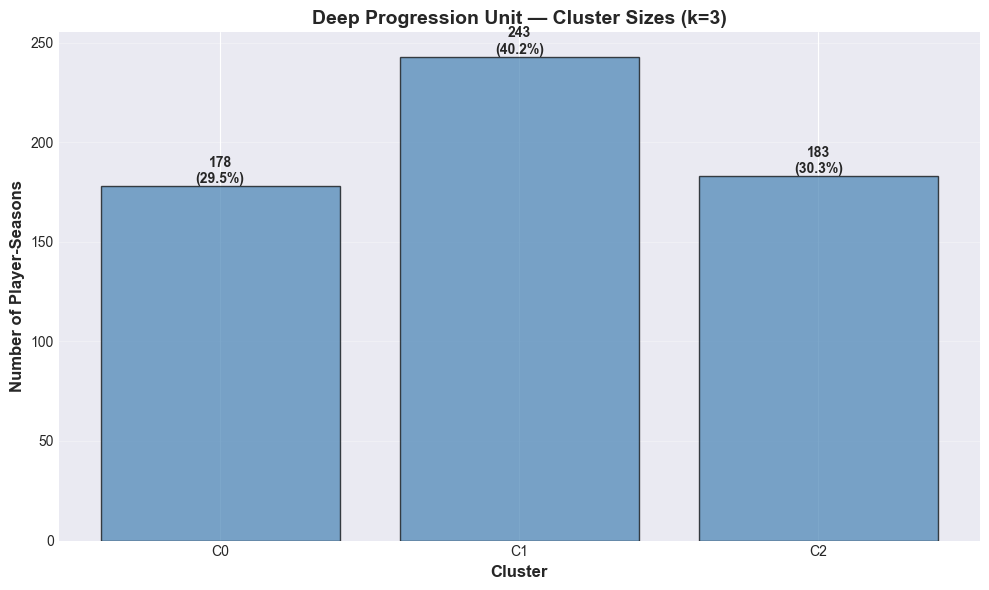

In [347]:
log_message("\n" + "="*80)
log_message("GENERATING VISUALIZATIONS")
log_message("="*80)

# Cluster sizes bar chart
fig, ax = plt.subplots(figsize=(10, 6))

clusters = cluster_sizes_df['cluster'].values
counts = cluster_sizes_df['count'].values
percentages = cluster_sizes_df['percentage'].values

bars = ax.bar(clusters, counts, alpha=0.7, color='steelblue', edgecolor='black')

# Add percentage labels on bars
for i, (bar, pct) in enumerate(zip(bars, percentages)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(counts[i])}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Player-Seasons', fontsize=12, fontweight='bold')
ax.set_title(f'Deep Progression Unit — Cluster Sizes (k={K})', fontsize=14, fontweight='bold')
ax.set_xticks(clusters)
ax.set_xticklabels([f'C{c}' for c in clusters])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

save_path = plots_dir / "cluster_sizes.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
log_message(f"✓ Saved cluster sizes plot: {save_path.name}")

plt.show()


### Visualizations: Centroid PC Bars (per cluster)


### Visualizations: Cluster Scatter Plots with Boundaries


In [348]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def draw_ellipse(position, covariance, ax=None, n_std=2.0, **kwargs):
    """
    Draw an ellipse representing the covariance matrix at n_std standard deviations.
    """
    if ax is None:
        ax = plt.gca()

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    
    # Compute angle and width/height
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigenvalues)
    
    # Draw ellipse
    ellipse = Ellipse(position, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

def plot_cluster_scatter_2d(X, labels, gmm_model, pc_x=0, pc_y=1, 
                             player_info=None, save_path=None):
    """
    Plot 2D scatter of clusters with GMM ellipses.
    
    Parameters:
    - X: L2-normalized abilities (n_samples, n_features)
    - labels: Cluster assignments
    - gmm_model: Fitted GMM model
    - pc_x, pc_y: Which PC dimensions to plot (0-indexed)
    - player_info: Optional DataFrame with player metadata for tooltips
    - save_path: Path to save figure
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Define colors for clusters
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    
    # Plot each cluster
    for c in range(K):
        cluster_mask = labels == c
        cluster_points = X[cluster_mask]
        
        # Plot points
        ax.scatter(
            cluster_points[:, pc_x], 
            cluster_points[:, pc_y],
            c=[colors[c]], 
            label=f'Cluster {c} (n={cluster_mask.sum()})',
            alpha=0.6,
            s=30,
            edgecolors='black',
            linewidth=0.3
        )
        
        # Draw covariance ellipse (2 standard deviations)
        if gmm_model.covariance_type == 'full':
            # Extract 2D covariance for this cluster
            cov_2d = gmm_model.covariances_[c][[pc_x, pc_y], :][:, [pc_x, pc_y]]
            mean_2d = gmm_model.means_[c][[pc_x, pc_y]]
            
            draw_ellipse(mean_2d, cov_2d, ax=ax, n_std=2.0,
                        edgecolor=colors[c], facecolor='none', 
                        linewidth=2.5, linestyle='--', alpha=0.8)
    
    # Labels and formatting
    ax.set_xlabel(f'PC{pc_x+1} (L2-normalized)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC{pc_y+1} (L2-normalized)', fontsize=12, fontweight='bold')
    ax.set_title(f'Deep Progression Unit — Cluster Distribution (PC{pc_x+1} vs PC{pc_y+1})',
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='black', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"  ✓ Saved scatter plot: PC{pc_x+1} vs PC{pc_y+1}")
    
    plt.show()

log_message("\n" + "="*80)
log_message("GENERATING CLUSTER SCATTER PLOTS")
log_message("="*80)

print("Creating 2D scatter plots with cluster boundaries...")


[INFO] 
[INFO] GENERATING CLUSTER SCATTER PLOTS
[INFO] ================================================================================
Creating 2D scatter plots with cluster boundaries...


[INFO]   ✓ Saved scatter plot: PC1 vs PC2


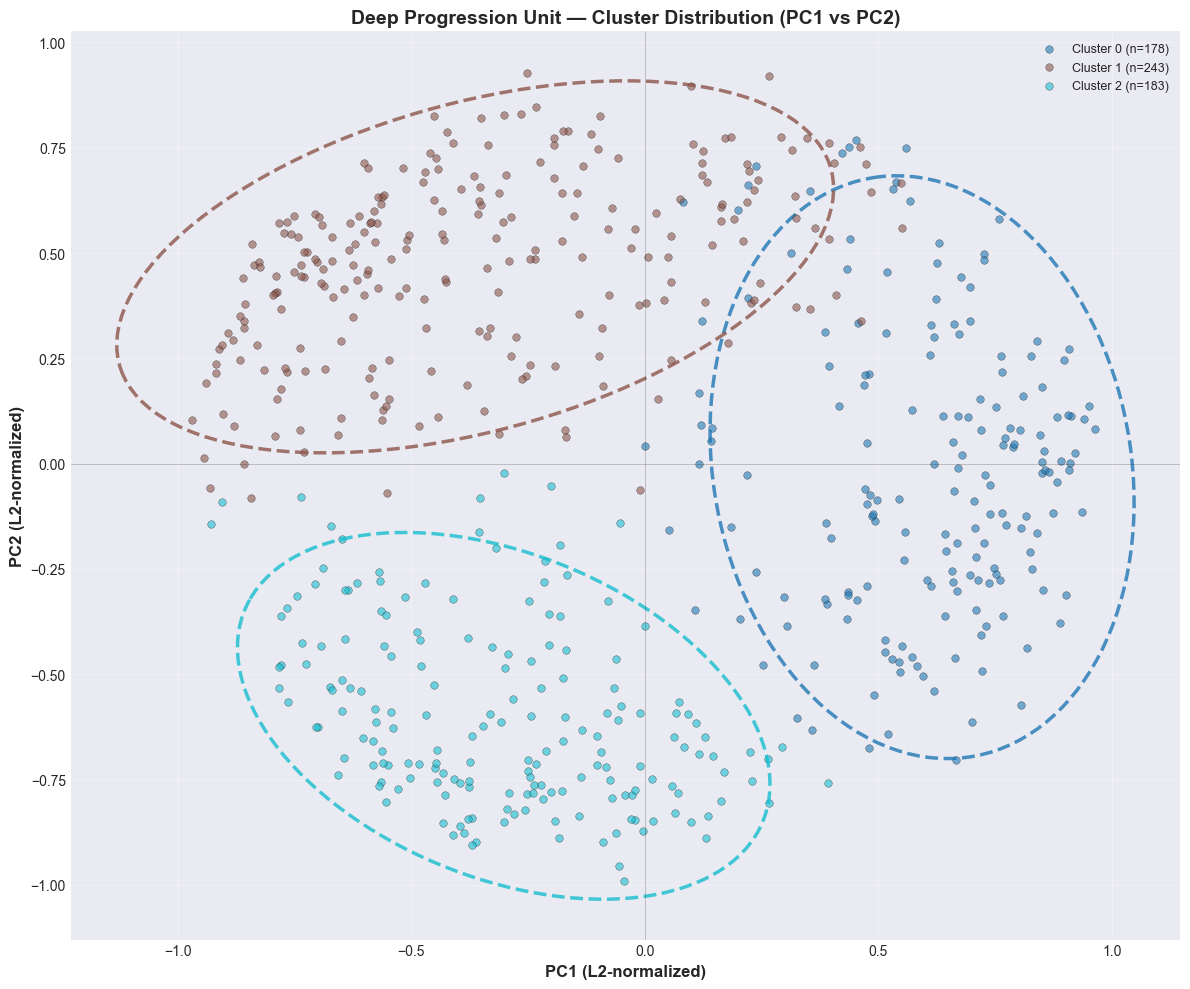

[INFO]   ✓ Saved scatter plot: PC1 vs PC3


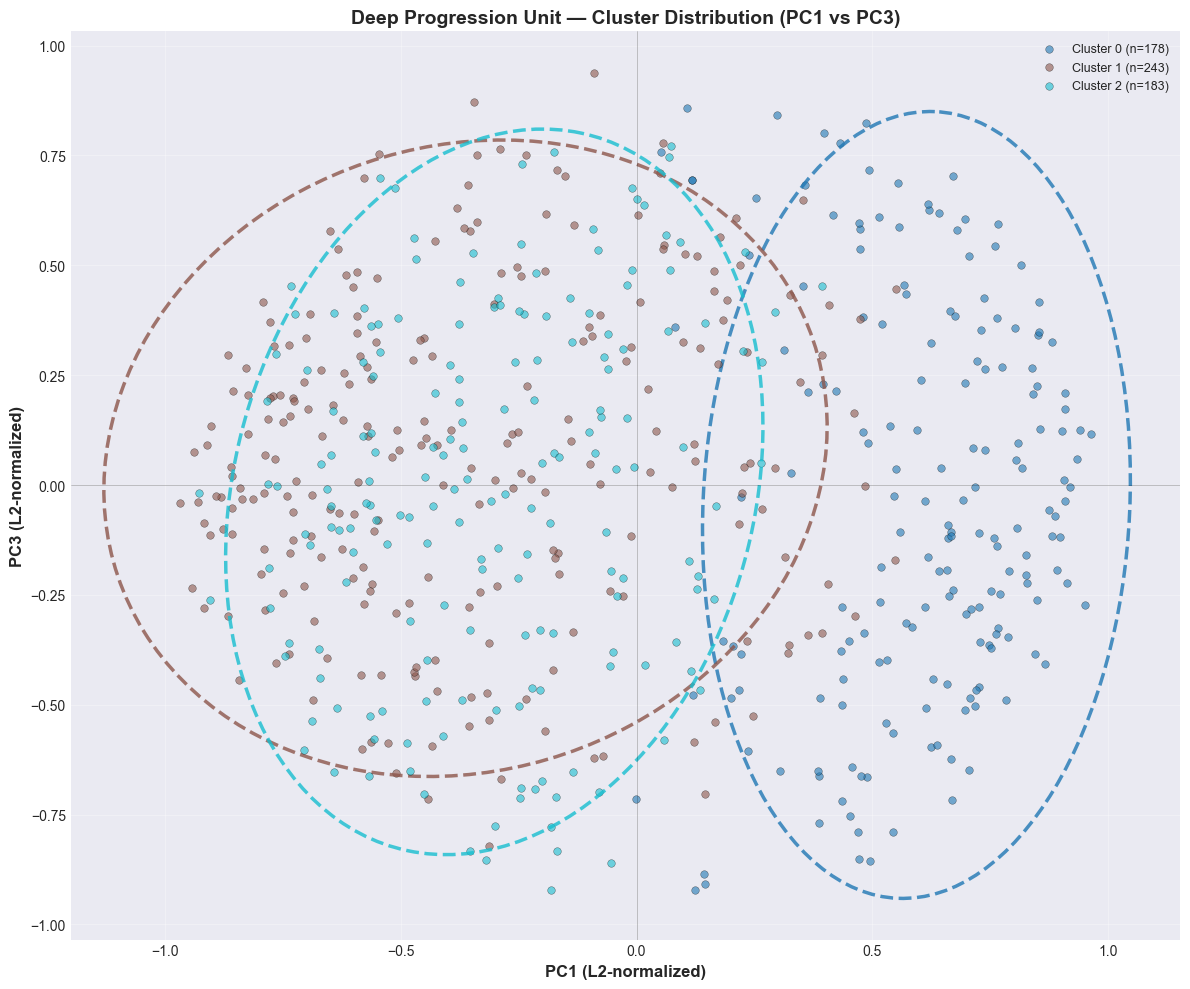

[INFO]   ✓ Saved scatter plot: PC2 vs PC3


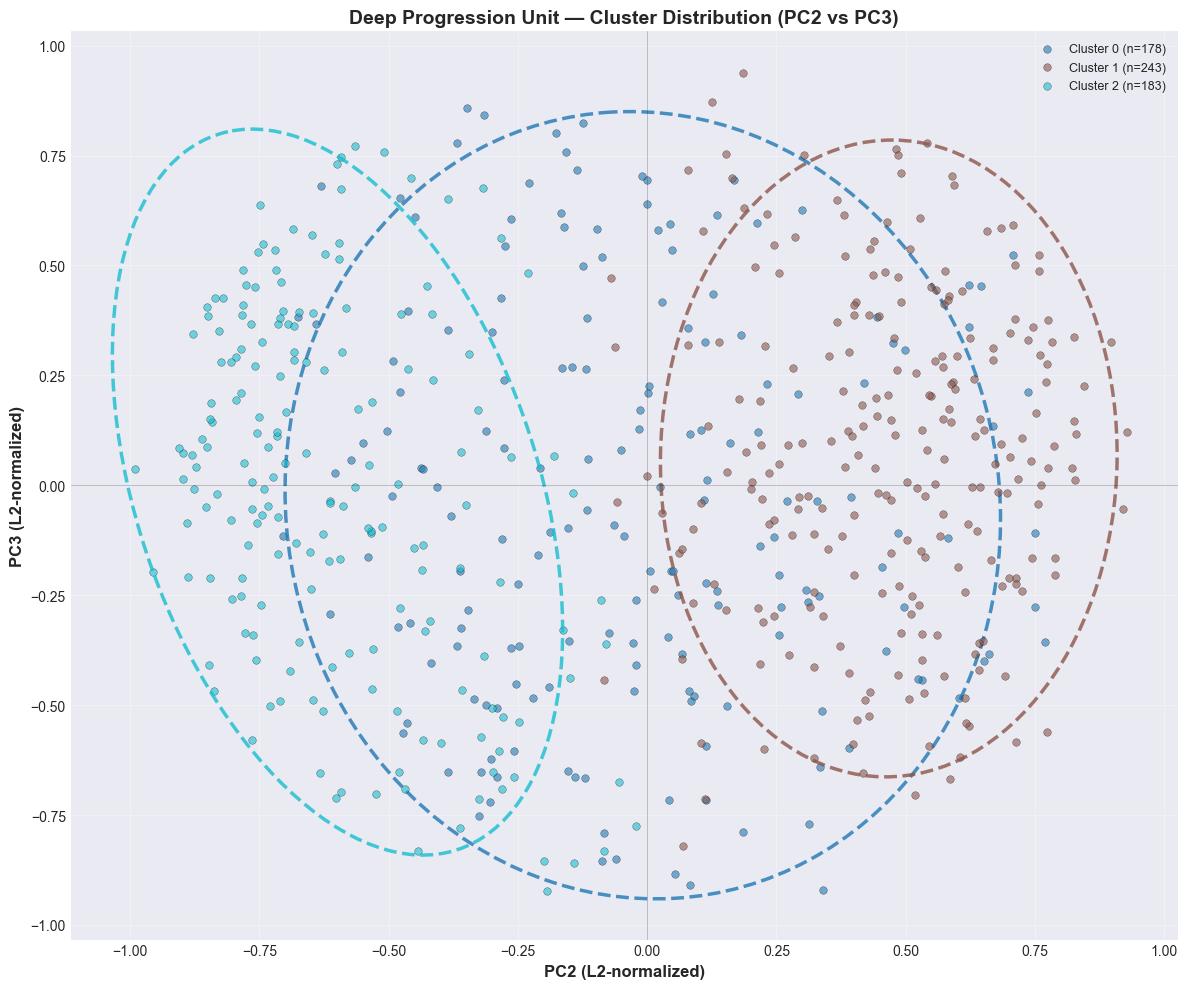

[INFO]   ✓ Saved scatter plot: PC3 vs PC4


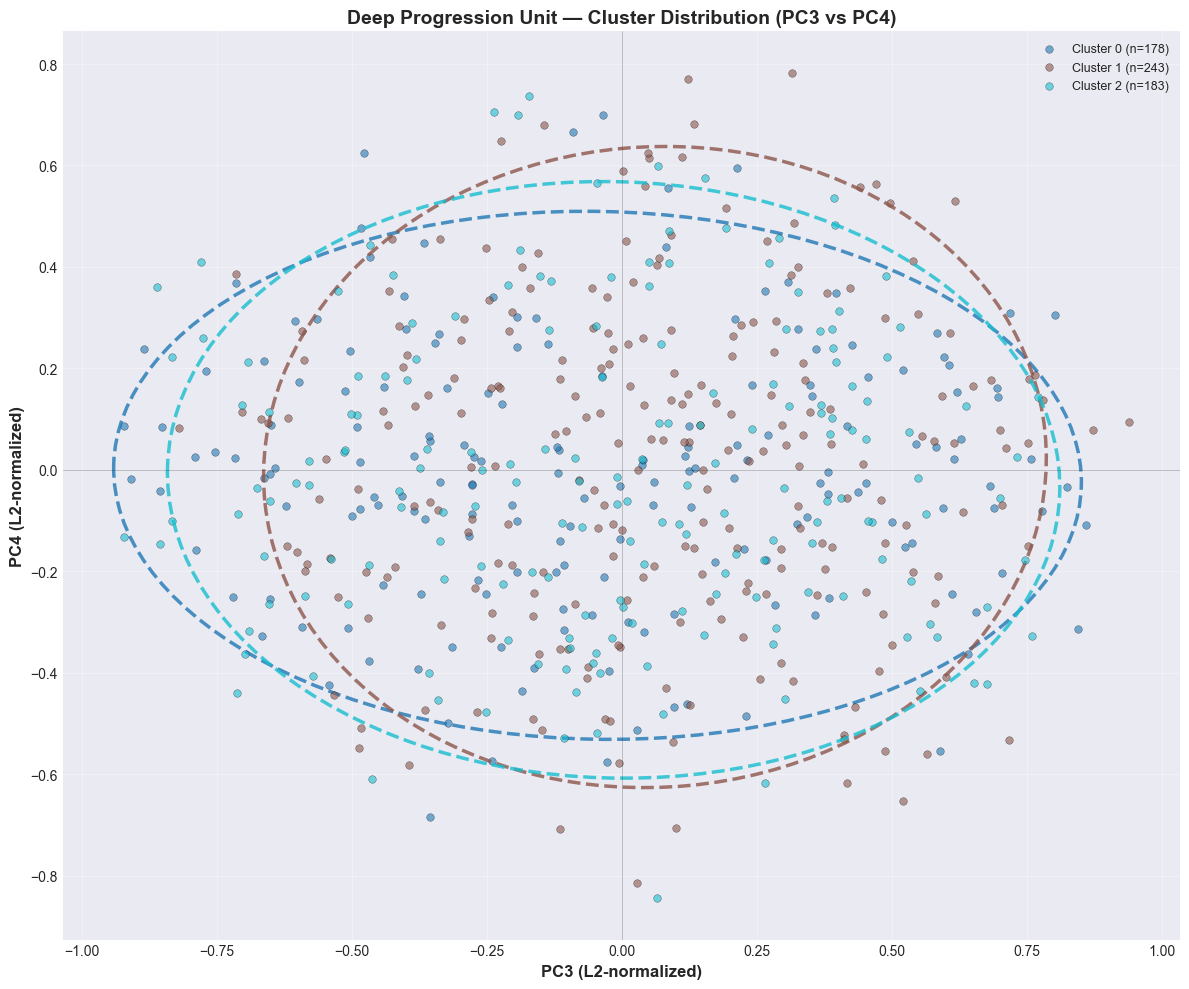

[INFO]   ✓ Saved scatter plot: PC1 vs PC4


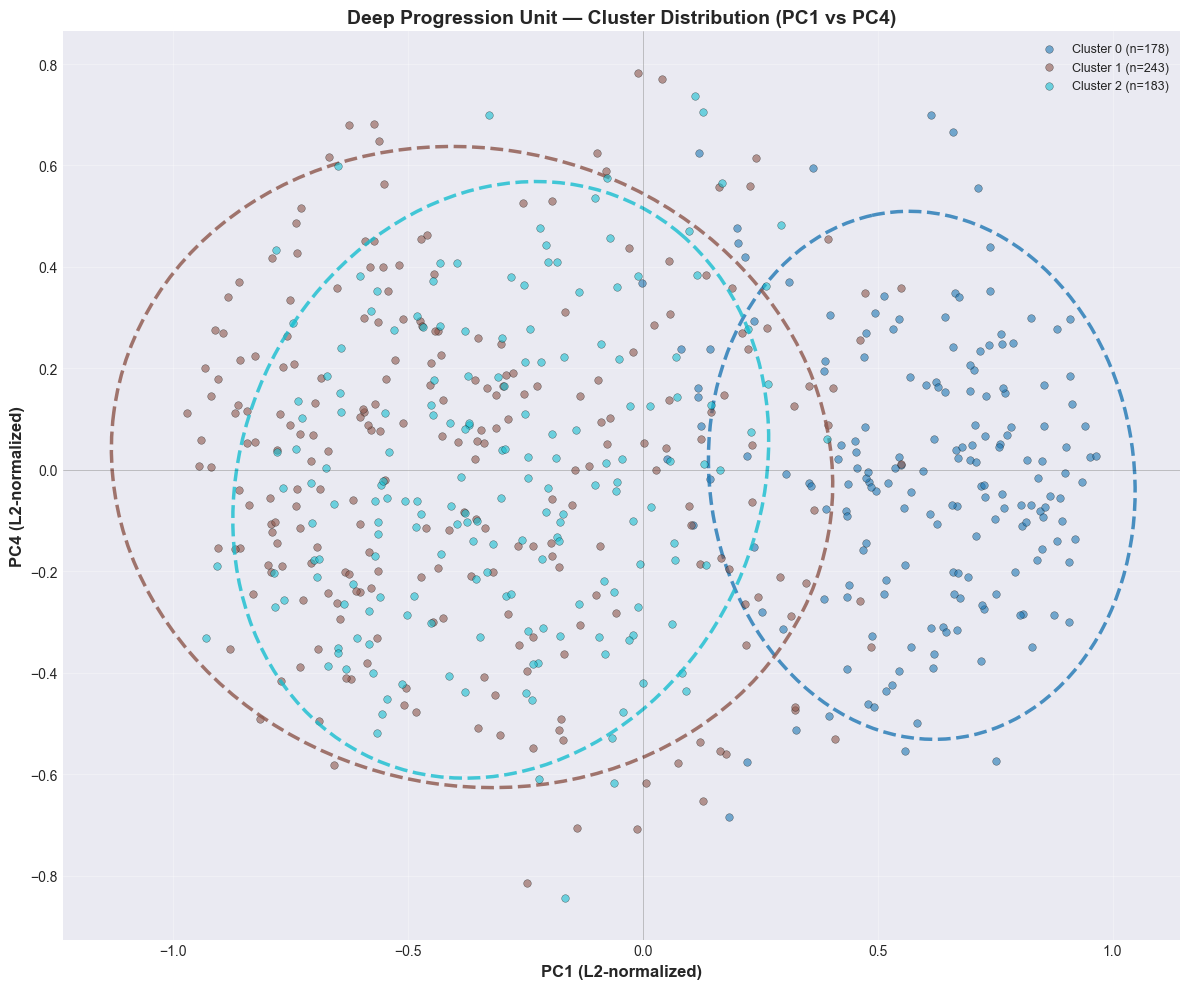

[INFO]   ✓ Saved scatter plot: PC2 vs PC4


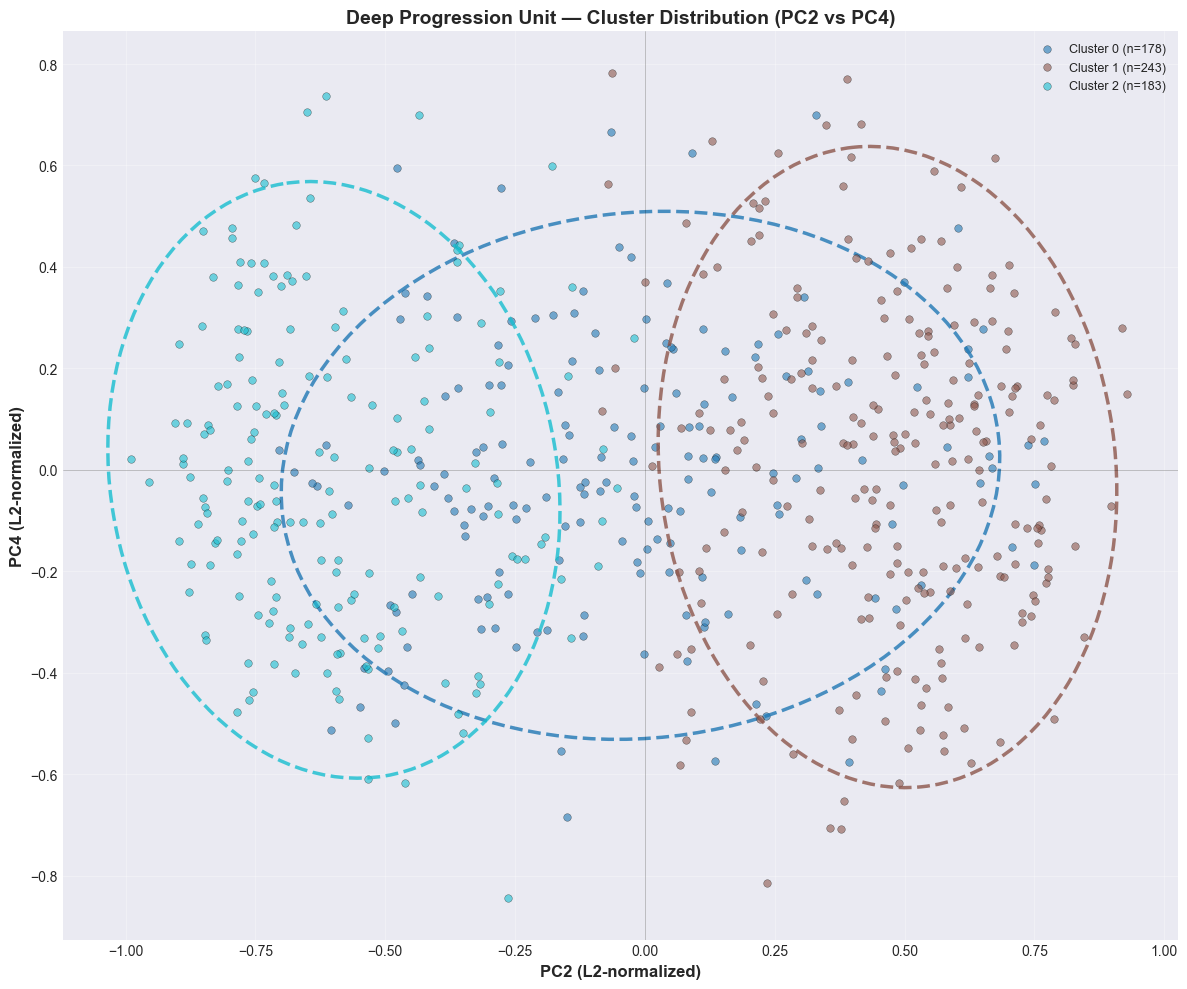

[INFO] ✓ Generated 6 cluster scatter plots with ellipses


In [349]:
# Generate scatter plots for key PC combinations
pc_pairs = [
    (0, 1),  # PC1 vs PC2
    (0, 2),  # PC1 vs PC3
    (1, 2),  # PC2 vs PC3
    (2, 3),  # PC3 vs PC4
    (0, 3),  # PC1 vs PC4
    (1, 3),  # PC2 vs PC4
]

for pc_x, pc_y in pc_pairs:
    save_path = plots_dir / f"cluster_scatter_PC{pc_x+1}_vs_PC{pc_y+1}.png"
    plot_cluster_scatter_2d(
        abilities_l2_normalized, 
        labels_final, 
        gmm_final,
        pc_x=pc_x, 
        pc_y=pc_y,
        save_path=save_path
    )

log_message(f"✓ Generated {len(pc_pairs)} cluster scatter plots with ellipses")


### Visualizations: Probability Heatmap


[INFO] 
Generating probability density heatmaps...
[INFO]   ✓ Saved probability heatmap: PC1 vs PC2


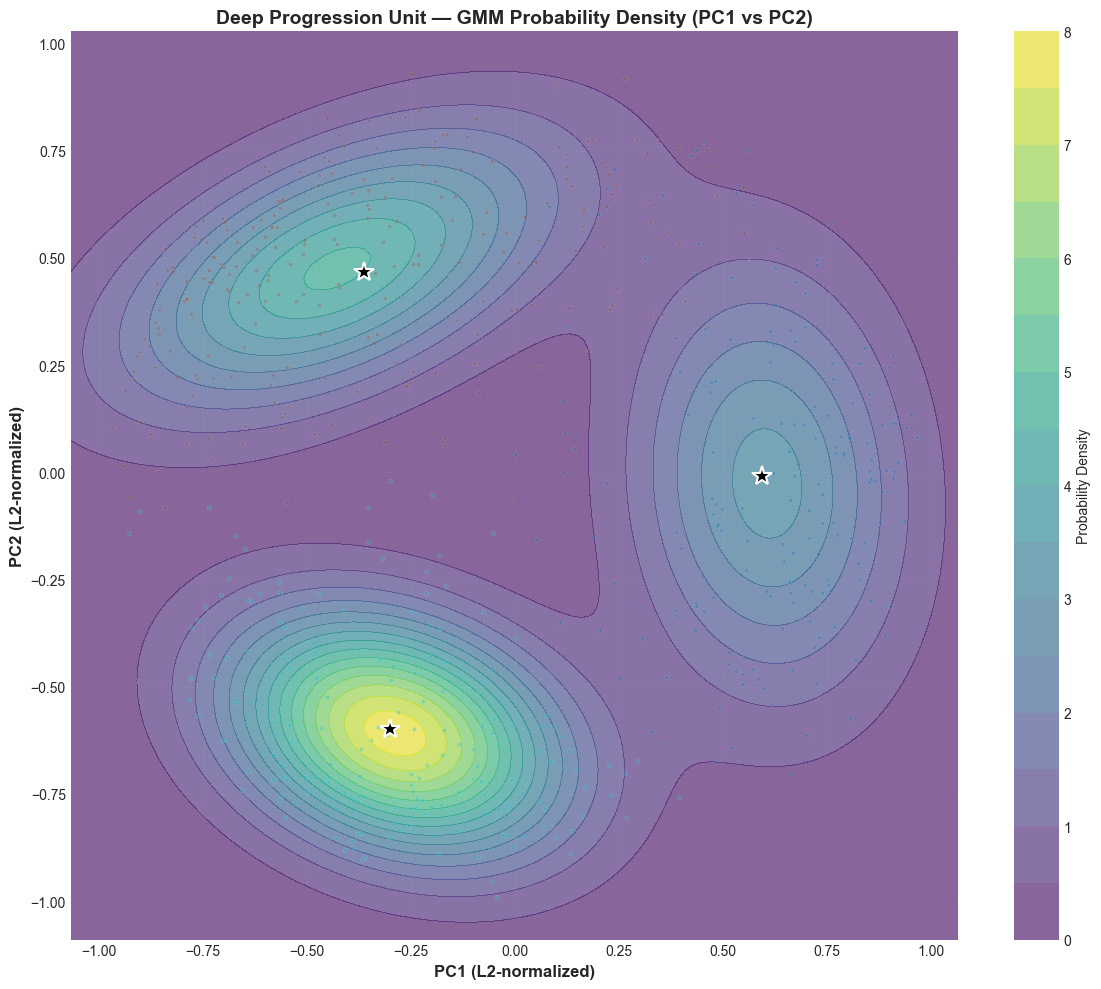

[INFO]   ✓ Saved probability heatmap: PC1 vs PC3


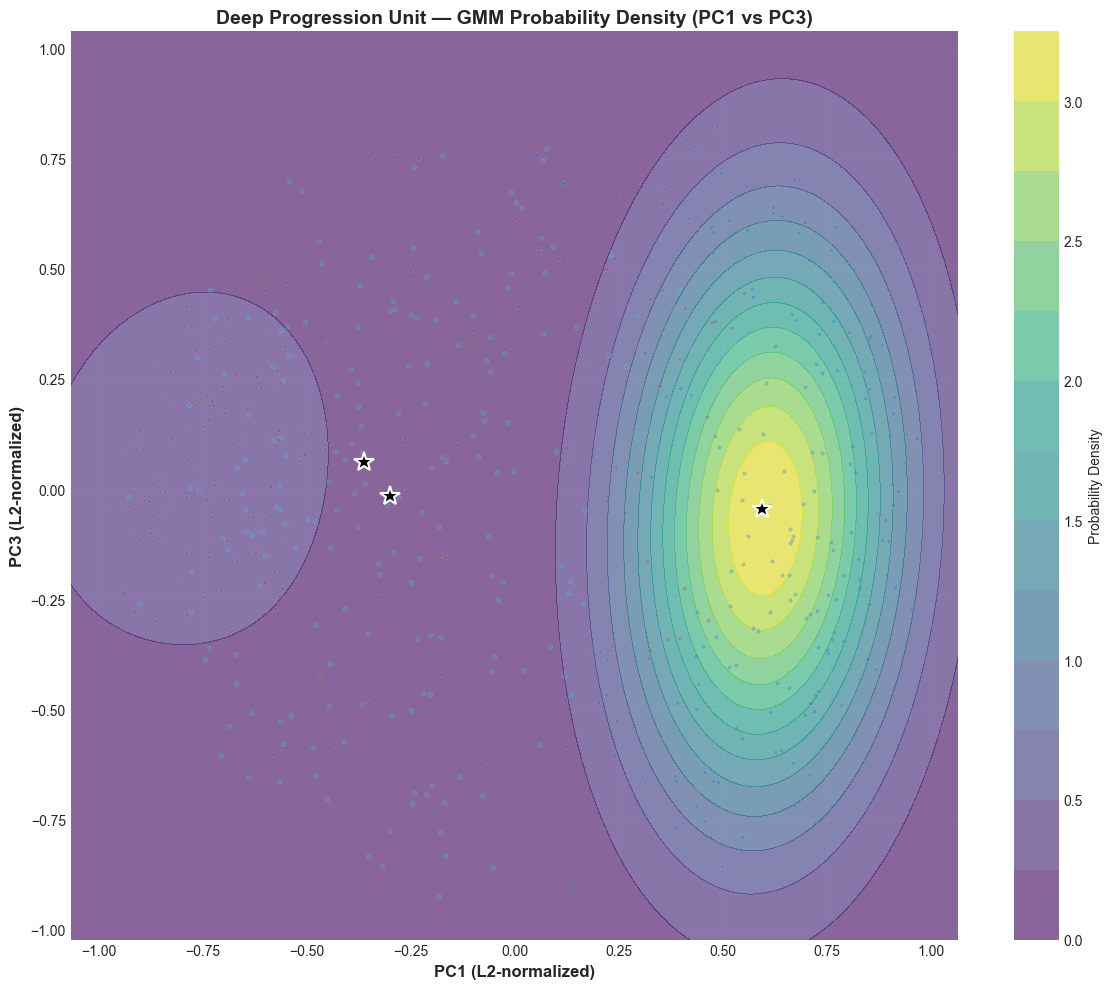

[INFO]   ✓ Saved probability heatmap: PC2 vs PC3


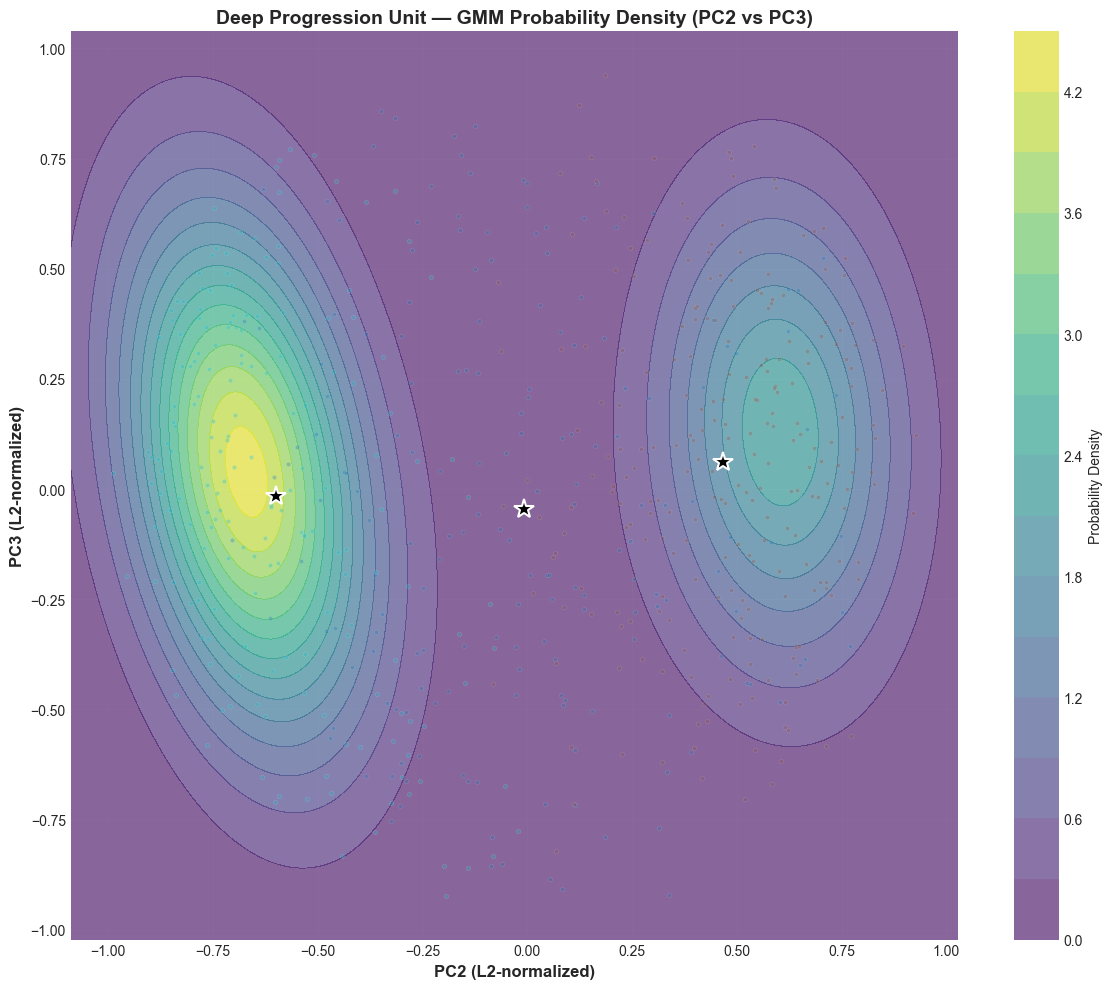

[INFO] ✓ Generated 3 probability density heatmaps


In [350]:
def plot_probability_heatmap(X, gmm_model, pc_x=0, pc_y=1, save_path=None):
    """
    Plot probability density heatmap for GMM in 2D PC space.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create grid for probability evaluation
    x_min, x_max = X[:, pc_x].min() - 0.1, X[:, pc_x].max() + 0.1
    y_min, y_max = X[:, pc_y].min() - 0.1, X[:, pc_y].max() + 0.1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    
    # Create full feature array (use zeros for other dimensions)
    grid_shape = (xx.ravel().shape[0], X.shape[1])
    grid_points = np.zeros(grid_shape)
    grid_points[:, pc_x] = xx.ravel()
    grid_points[:, pc_y] = yy.ravel()
    
    # Score (log probability density)
    Z = gmm_model.score_samples(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Plot probability density
    contour = ax.contourf(xx, yy, np.exp(Z), levels=15, cmap='viridis', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='Probability Density')
    
    # Overlay actual data points
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    labels = gmm_model.predict(X)
    
    for c in range(K):
        cluster_mask = labels == c
        cluster_points = X[cluster_mask]
        ax.scatter(
            cluster_points[:, pc_x], 
            cluster_points[:, pc_y],
            c=[colors[c]], 
            alpha=0.3,
            s=10,
            edgecolors='white',
            linewidth=0.2
        )
    
    # Plot cluster means
    for c in range(K):
        mean_2d = gmm_model.means_[c][[pc_x, pc_y]]
        ax.plot(mean_2d[0], mean_2d[1], 'k*', markersize=15, 
               markeredgecolor='white', markeredgewidth=1.5)
    
    ax.set_xlabel(f'PC{pc_x+1} (L2-normalized)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC{pc_y+1} (L2-normalized)', fontsize=12, fontweight='bold')
    ax.set_title(f'Deep Progression Unit — GMM Probability Density (PC{pc_x+1} vs PC{pc_y+1})',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"  ✓ Saved probability heatmap: PC{pc_x+1} vs PC{pc_y+1}")
    
    plt.show()

log_message("\nGenerating probability density heatmaps...")

# Generate heatmaps for key PC combinations
key_pairs = [(0, 1), (0, 2), (1, 2)]

for pc_x, pc_y in key_pairs:
    save_path = plots_dir / f"cluster_probability_PC{pc_x+1}_vs_PC{pc_y+1}.png"
    plot_probability_heatmap(
        abilities_l2_normalized,
        gmm_final,
        pc_x=pc_x,
        pc_y=pc_y,
        save_path=save_path
    )

log_message(f"✓ Generated {len(key_pairs)} probability density heatmaps")


### Cluster Quality Diagnostics


In [351]:
log_message("\n" + "="*80)
log_message("CLUSTER QUALITY DIAGNOSTICS")
log_message("="*80)

# 1. Assignment confidence (max probability)
max_probs = probs.max(axis=1)

log_message("\n📊 Assignment Confidence (based on max probability):")
log_message(f"  - Mean max probability: {max_probs.mean():.3f}")
log_message(f"  - Median max probability: {np.median(max_probs):.3f}")

# Confidence categories
very_clear = (max_probs >= 0.80).sum()
clear = ((max_probs >= 0.60) & (max_probs < 0.80)).sum()
moderate = ((max_probs >= 0.40) & (max_probs < 0.60)).sum()
ambiguous = (max_probs < 0.40).sum()

log_message(f"\n  Assignment clarity breakdown:")
log_message(f"    - Very clear (p≥0.80): {very_clear} ({100*very_clear/len(max_probs):.1f}%)")
log_message(f"    - Clear (0.60≤p<0.80): {clear} ({100*clear/len(max_probs):.1f}%)")
log_message(f"    - Moderate (0.40≤p<0.60): {moderate} ({100*moderate/len(max_probs):.1f}%)")
log_message(f"    - Ambiguous (p<0.40): {ambiguous} ({100*ambiguous/len(max_probs):.1f}%)")

# 2. Cluster separation (mean distance between centroids)
centroid_distances = []
for i in range(K):
    for j in range(i+1, K):
        dist = np.linalg.norm(gmm_final.means_[i] - gmm_final.means_[j])
        centroid_distances.append(dist)

log_message(f"\n📏 Cluster Separation:")
log_message(f"  - Mean distance between centroids: {np.mean(centroid_distances):.3f}")
log_message(f"  - Min distance between centroids: {np.min(centroid_distances):.3f}")
log_message(f"  - Max distance between centroids: {np.max(centroid_distances):.3f}")

# 3. Within-cluster variance
within_cluster_variance = []
for c in range(K):
    cluster_mask = labels_final == c
    cluster_points = abilities_l2_normalized[cluster_mask]
    centroid = gmm_final.means_[c]
    variance = np.mean(np.sum((cluster_points - centroid)**2, axis=1))
    within_cluster_variance.append(variance)

log_message(f"\n📐 Within-Cluster Variance (compactness):")
log_message(f"  - Mean: {np.mean(within_cluster_variance):.4f}")
log_message(f"  - Range: [{np.min(within_cluster_variance):.4f}, {np.max(within_cluster_variance):.4f}]")

# 4. Silhouette score (already computed, but let's show it again)
log_message(f"\n🎯 Overall Quality Metrics:")
log_message(f"  - Silhouette score: {silhouette_final:.4f}")
log_message(f"    (Range: -1 to 1, higher is better)")
log_message(f"    • 0.7-1.0: Strong structure")
log_message(f"    • 0.5-0.7: Reasonable structure")
log_message(f"    • 0.25-0.5: Weak structure")
log_message(f"    • <0.25: No substantial structure")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("Cluster overlap is EXPECTED when:")
print("  1. Using L2 normalization (captures style, not quality)")
print("  2. Working in high-dimensional space (7D) but viewing in 2D")
print("  3. Using GMM (soft/probabilistic boundaries, not hard clusters)")
print("  4. Analyzing diverse positions (full-backs vs midfielders)")
print("\nThis overlap means players can exhibit MIXED styles, which is realistic!")
print("="*80)


[INFO] 
[INFO] CLUSTER QUALITY DIAGNOSTICS
[INFO] ================================================================================
[INFO] 
📊 Assignment Confidence (based on max probability):
[INFO]   - Mean max probability: 0.973
[INFO]   - Median max probability: 1.000
[INFO] 
  Assignment clarity breakdown:
[INFO]     - Very clear (p≥0.80): 574 (95.0%)
[INFO]     - Clear (0.60≤p<0.80): 15 (2.5%)
[INFO]     - Moderate (0.40≤p<0.60): 15 (2.5%)
[INFO]     - Ambiguous (p<0.40): 0 (0.0%)
[INFO] 
📏 Cluster Separation:
[INFO]   - Mean distance between centroids: 1.081
[INFO]   - Min distance between centroids: 1.074
[INFO]   - Max distance between centroids: 1.090
[INFO] 
📐 Within-Cluster Variance (compactness):
[INFO]   - Mean: 0.6041
[INFO]   - Range: [0.5427, 0.6379]
[INFO] 
🎯 Overall Quality Metrics:
[INFO]   - Silhouette score: 0.2447
[INFO]     (Range: -1 to 1, higher is better)
[INFO]     • 0.7-1.0: Strong structure
[INFO]     • 0.5-0.7: Reasonable structure
[INFO]     • 0.25-0.5: We

### Suggested Actions Based on Silhouette Score


In [352]:
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

if silhouette_final >= 0.5:
    print("✅ Your silhouette score suggests reasonable cluster structure.")
    print("   The overlap is likely due to:")
    print("   - Soft GMM boundaries (which is good for player styles)")
    print("   - 2D projection of 7D space")
    print("   - Natural gradation between playing styles")
    print("\n💡 This is NORMAL and USEFUL for player profiling!")
    
elif silhouette_final >= 0.25:
    print("⚠️  Your silhouette score suggests weak-to-moderate structure.")
    print("   Consider:")
    print("   1. Reviewing BIC/AIC curves - maybe try k=4 or k=5 instead")
    print("   2. Splitting analysis by position group:")
    print("      • Full-backs/Wing-backs separately")
    print("      • Holding midfielders separately")
    print("      • Central midfielders separately")
    print("   3. Using raw PC scores (not L2) if quality tiers matter")
    
else:
    print("❌ Your silhouette score suggests very weak structure.")
    print("   Strong recommendations:")
    print("   1. Try fewer clusters (k=3 or k=4)")
    print("   2. Split by position groups (full-backs vs midfielders)")
    print("   3. Check if L2 normalization is appropriate for your use case")
    print("   4. Consider using raw PC scores instead")

print("\n" + "="*80)
print(f"Current configuration: k={K}, silhouette={silhouette_final:.3f}")
print("="*80)



RECOMMENDATIONS
❌ Your silhouette score suggests very weak structure.
   Strong recommendations:
   1. Try fewer clusters (k=3 or k=4)
   2. Split by position groups (full-backs vs midfielders)
   3. Check if L2 normalization is appropriate for your use case
   4. Consider using raw PC scores instead

Current configuration: k=3, silhouette=0.245


### Per-Cluster Silhouette Scores


[INFO] 
[INFO] PER-CLUSTER SILHOUETTE SCORES
[INFO] ================================================================================
[INFO] Cluster 0: 0.231 (n=178)
[INFO] Cluster 1: 0.219 (n=243)
[INFO] Cluster 2: 0.292 (n=183)
[INFO] 
✓ Saved silhouette plot: silhouette_plot.png


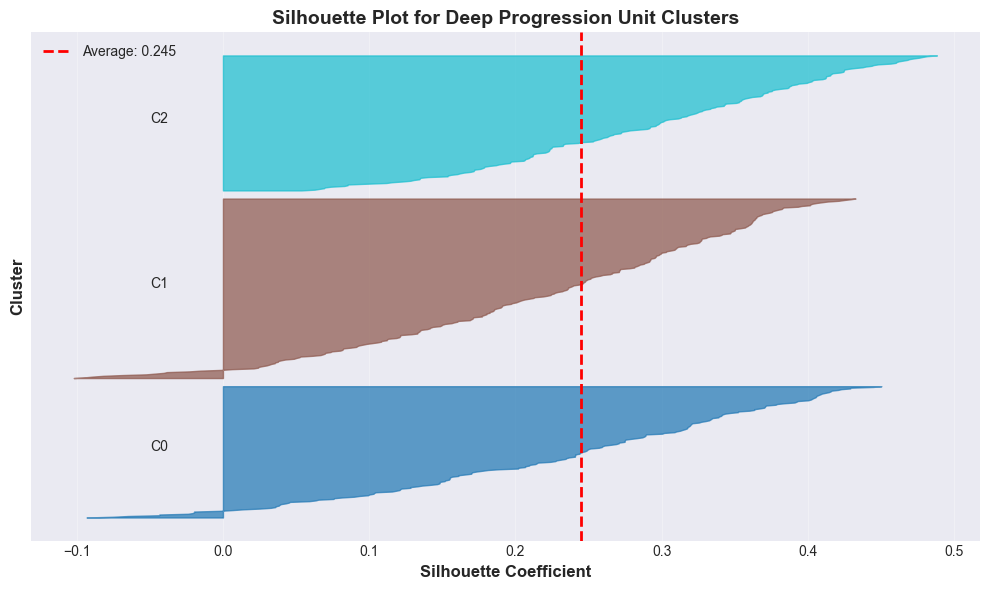

[INFO] 
Clusters with silhouette < 0.3 may be poorly defined or overlapping significantly.


In [353]:
from sklearn.metrics import silhouette_samples

# Compute per-sample silhouette scores
sample_silhouette_values = silhouette_samples(abilities_l2_normalized, labels_final)

# Compute per-cluster averages
log_message("\n" + "="*80)
log_message("PER-CLUSTER SILHOUETTE SCORES")
log_message("="*80)

cluster_silhouettes = []
for c in range(K):
    cluster_mask = labels_final == c
    cluster_silhouette = sample_silhouette_values[cluster_mask].mean()
    cluster_silhouettes.append(cluster_silhouette)
    cluster_size = cluster_mask.sum()
    
    log_message(f"Cluster {c}: {cluster_silhouette:.3f} (n={cluster_size})")

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
colors = plt.cm.tab10(np.linspace(0, 1, K))

for c in range(K):
    # Get silhouette values for this cluster
    cluster_mask = labels_final == c
    cluster_silhouette_values = sample_silhouette_values[cluster_mask]
    cluster_silhouette_values.sort()
    
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_values,
                     facecolor=colors[c], edgecolor=colors[c], alpha=0.7)
    
    # Label with cluster number
    ax.text(-0.05, y_lower + 0.5 * size_cluster, f'C{c}')
    
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
ax.set_title('Silhouette Plot for Deep Progression Unit Clusters', 
             fontsize=14, fontweight='bold')

# Add average silhouette line
ax.axvline(x=silhouette_final, color='red', linestyle='--', linewidth=2, 
           label=f'Average: {silhouette_final:.3f}')
ax.legend(loc='best')
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
save_path = plots_dir / "silhouette_plot.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
log_message(f"\n✓ Saved silhouette plot: {save_path.name}")

plt.show()

log_message(f"\nClusters with silhouette < 0.3 may be poorly defined or overlapping significantly.")


## 25. Understanding Low Silhouette Scores & Alternative Approaches

**Current Results:**
- k=3: silhouette = 0.24
- k=4: silhouette = 0.21

Both are in the "weak/no substantial structure" range (<0.25), suggesting the Deep Progression Unit cohort may not have strong natural style-based clustering when combining all position types.


In [354]:
print("="*80)
print("WHY ARE THE SILHOUETTE SCORES LOW?")
print("="*80)
print("\n📊 Possible Reasons:")
print("\n1. MIXING TOO MANY POSITION TYPES")
print("   • Full-backs/Wing-backs have very different roles than midfielders")
print("   • Defensive midfielders vs Central midfielders have different profiles")
print("   • L2 normalization removes quality but positions still matter")
print("\n2. L2 NORMALIZATION FOCUSES ON STYLE")
print("   • Removes magnitude differences (quality)")
print("   • Makes gradual transitions between styles (not discrete clusters)")
print("   • More realistic but less 'clean' clustering")
print("\n3. NATURAL GRADATION IN PLAYING STYLES")
print("   • Players aren't truly distinct types - there's a continuum")
print("   • Overlap is realistic, not a problem")
print("\n" + "="*80)
print("RECOMMENDED NEXT STEPS")
print("="*80)
print("\n✅ OPTION 1: Accept k=3 and interpret clusters")
print("   • Low silhouette doesn't mean clusters are meaningless")
print("   • They represent broad stylistic tendencies")
print("   • Use centroids + position distributions to name clusters")
print("   • Example: 'Defensive-oriented', 'Balanced', 'Progressive'")
print("\n✅ OPTION 2: Split by position groups (RECOMMENDED)")
print("   • Analyze Full-backs/Wing-backs separately (likely better clustering)")
print("   • Analyze Defensive midfielders separately")
print("   • Analyze Central midfielders separately")
print("   • Each position type will have cleaner clusters")
print("\n✅ OPTION 3: Use raw PC scores (not L2)")
print("   • Cluster by quality + style combined")
print("   • May give cleaner separation (quality tiers)")
print("   • But mixes performance level with style")
print("\n✅ OPTION 4: Use position-specific features")
print("   • Define features specific to each position group")
print("   • Full-backs: crossing, wide positioning, overlaps")
print("   • Midfielders: passing range, ball-winning, box-to-box")
print("\n" + "="*80)
print("CURRENT RECOMMENDATION")
print("="*80)
print("Since BIC strongly suggested k=3 and you have silhouette=0.24,")
print("PROCEED WITH k=3 for now and:")
print("  1. Examine cluster centroids and loadings")
print("  2. Look at position distributions per cluster")
print("  3. Find representative players for each cluster")
print("  4. Name clusters based on their characteristics")
print("\nIf the k=3 clusters don't make tactical sense,")
print("then try OPTION 2 (split by position groups).")
print("="*80)


WHY ARE THE SILHOUETTE SCORES LOW?

📊 Possible Reasons:

1. MIXING TOO MANY POSITION TYPES
   • Full-backs/Wing-backs have very different roles than midfielders
   • Defensive midfielders vs Central midfielders have different profiles
   • L2 normalization removes quality but positions still matter

2. L2 NORMALIZATION FOCUSES ON STYLE
   • Removes magnitude differences (quality)
   • Makes gradual transitions between styles (not discrete clusters)
   • More realistic but less 'clean' clustering

3. NATURAL GRADATION IN PLAYING STYLES
   • Players aren't truly distinct types - there's a continuum
   • Overlap is realistic, not a problem

RECOMMENDED NEXT STEPS

✅ OPTION 1: Accept k=3 and interpret clusters
   • Low silhouette doesn't mean clusters are meaningless
   • They represent broad stylistic tendencies
   • Use centroids + position distributions to name clusters
   • Example: 'Defensive-oriented', 'Balanced', 'Progressive'

✅ OPTION 2: Split by position groups (RECOMMENDED)
   •

[INFO] 
Generating centroid PC bar charts...
[INFO]   ✓ Saved centroid plot for cluster 0


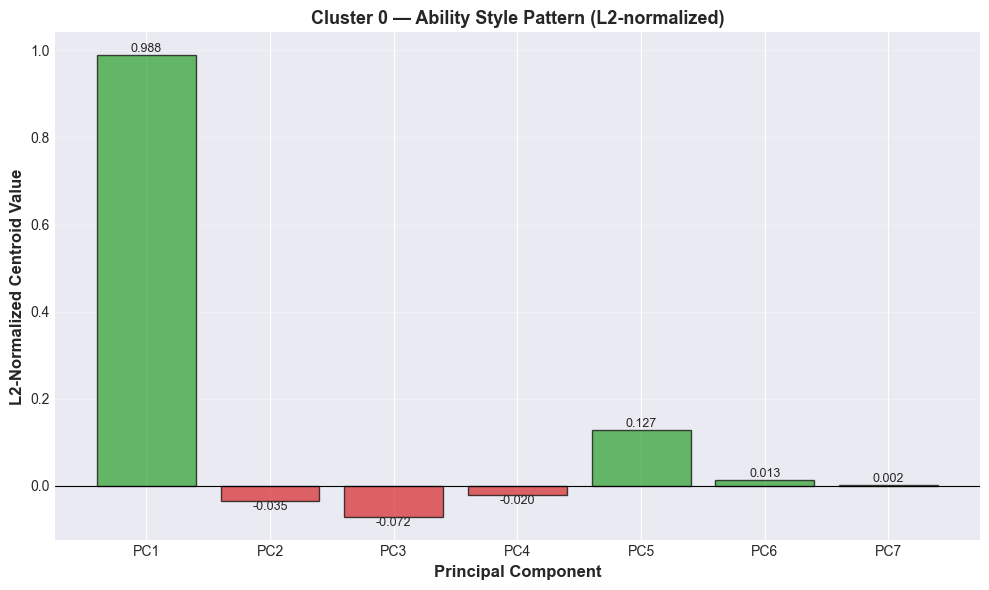

[INFO]   ✓ Saved centroid plot for cluster 1


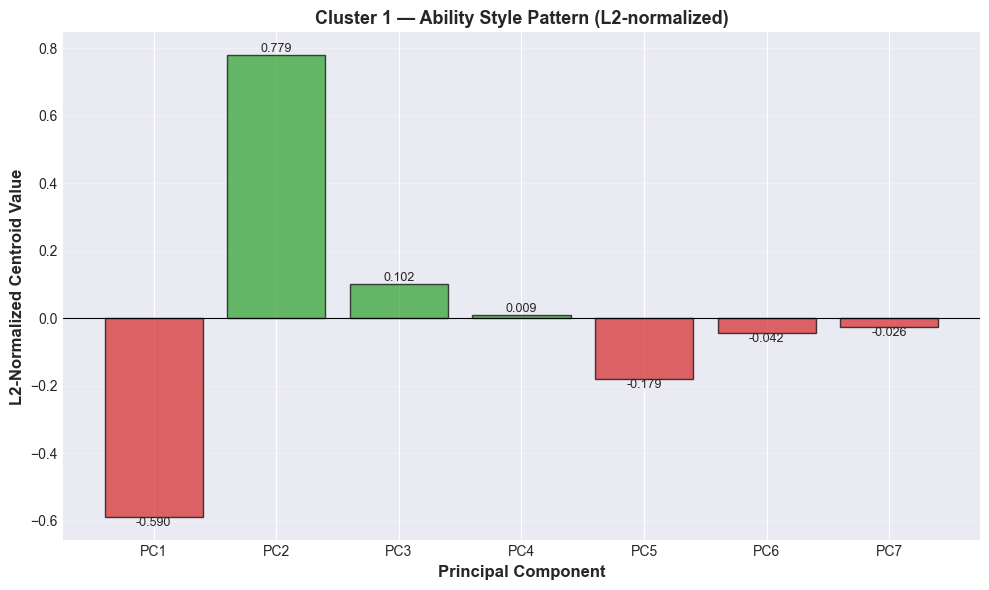

[INFO]   ✓ Saved centroid plot for cluster 2


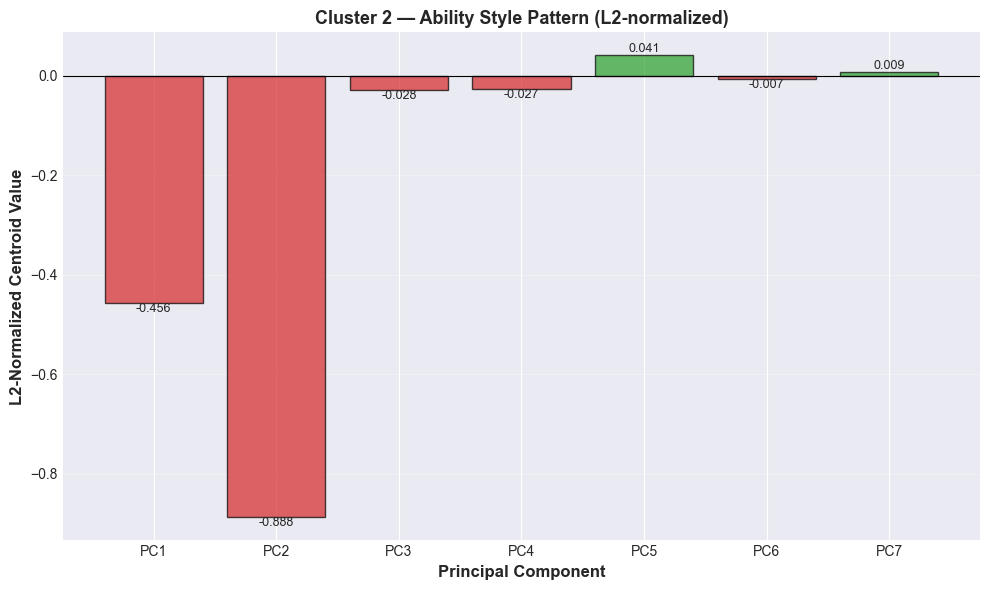

[INFO] ✓ Generated 3 centroid bar charts


In [355]:
def plot_cluster_centroid_bars(cluster_id, centroid_values, save_path=None):
    """
    Plot bar chart of PC values for a cluster's L2-style centroid.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    pcs = np.arange(1, len(centroid_values) + 1)
    colors = ['#2ca02c' if v > 0 else '#d62728' for v in centroid_values]
    
    bars = ax.bar(pcs, centroid_values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels
    for i, (pc, val) in enumerate(zip(pcs, centroid_values)):
        ax.text(pc, val, f'{val:.3f}', ha='center', 
                va='bottom' if val > 0 else 'top', fontsize=9)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
    ax.set_ylabel('L2-Normalized Centroid Value', fontsize=12, fontweight='bold')
    ax.set_title(f'Cluster {cluster_id} — Ability Style Pattern (L2-normalized)', 
                 fontsize=13, fontweight='bold')
    ax.set_xticks(pcs)
    ax.set_xticklabels([f'PC{i}' for i in pcs])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        log_message(f"  ✓ Saved centroid plot for cluster {cluster_id}")
    
    plt.show()

# Generate centroid plots for each cluster
log_message("\nGenerating centroid PC bar charts...")

for c in range(K):
    centroid_vals = centroids_l2_style.loc[c].values
    save_path = plots_dir / f"centroid_pc_bars_cluster{c}.png"
    plot_cluster_centroid_bars(c, centroid_vals, save_path)

log_message(f"✓ Generated {K} centroid bar charts")


## 24. Final Summary: GMM Clustering Complete


In [356]:
log_message("\n" + "="*80)
log_message("🎉 GMM CLUSTERING COMPLETE!")
log_message("="*80)

log_message(f"\n📊 Final Model Summary:")
log_message(f"  - Clusters (k): {K}")
log_message(f"  - Observations: {len(pca_scores_df)} player-seasons")
log_message(f"  - Dimensions: {n_components_for_clustering}D ability space")
log_message(f"  - Normalization: L2 (row-wise)")
log_message(f"  - BIC: {bic_final:.2f}")
log_message(f"  - AIC: {aic_final:.2f}")
log_message(f"  - Silhouette score: {silhouette_final:.4f}")

log_message(f"\n📁 Artifacts Location:")
log_message(f"  {gmm_k6_dir.absolute()}")

log_message(f"\n📄 Key Files Generated:")
log_message(f"  ✓ gmm_model_k{K}.joblib")
log_message(f"  ✓ model_summary.json")
log_message(f"  ✓ cluster_assignments.csv")
log_message(f"  ✓ cluster_probabilities.csv")
log_message(f"  ✓ players_with_clusters.csv")
log_message(f"  ✓ centroids_raw.csv")
log_message(f"  ✓ centroids_l2_style.csv")
log_message(f"  ✓ position_counts_primary.csv")
log_message(f"  ✓ position_counts_primary_secondary.csv")
log_message(f"  ✓ cluster_sizes.csv")
log_message(f"  ✓ plots/cluster_sizes.png")
log_message(f"  ✓ plots/centroid_pc_bars_cluster*.png ({K} files)")

log_message(f"\n🎯 Cluster Sizes:")
for _, row in cluster_sizes_df.iterrows():
    log_message(f"  - Cluster {int(row['cluster'])}: {int(row['count'])} players ({row['percentage']:.1f}%)")

log_message(f"\n✅ Ready for cluster interpretation and analysis!")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("1. Review cluster centroids (centroids_l2_style.csv) to understand style patterns")
print("2. Examine position distributions per cluster (position_counts_primary.csv)")
print("3. Analyze PCA loadings to interpret what each PC represents")
print("4. Label clusters based on their characteristic abilities and positions")
print("5. Generate player examples for each cluster")
print("="*80)


[INFO] 
[INFO] 🎉 GMM CLUSTERING COMPLETE!
[INFO] ================================================================================
[INFO] 
📊 Final Model Summary:
[INFO]   - Clusters (k): 3
[INFO]   - Observations: 604 player-seasons
[INFO]   - Dimensions: 7D ability space
[INFO]   - Normalization: L2 (row-wise)
[INFO]   - BIC: 2859.09
[INFO]   - AIC: 2387.90
[INFO]   - Silhouette score: 0.2447
[INFO] 
📁 Artifacts Location:
[INFO]   c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\deep_progression_artifacts\gmm_k3
[INFO] 
📄 Key Files Generated:
[INFO]   ✓ gmm_model_k3.joblib
[INFO]   ✓ model_summary.json
[INFO]   ✓ cluster_assignments.csv
[INFO]   ✓ cluster_probabilities.csv
[INFO]   ✓ players_with_clusters.csv
[INFO]   ✓ centroids_raw.csv
[INFO]   ✓ centroids_l2_style.csv
[INFO]   ✓ position_counts_primary.csv
[INFO]   ✓ position_counts_primary_secondary.csv
[INFO]   ✓ cluster_sizes.csv
[INFO]   ✓ plot